<h1>Marche à suivre pour mener un projet de data science</h1>
<h2>1 --> Définir un objectif mesurable:</h2>
	* Objectif : Prédire sur une personne est infectée en fonction des données cliniques disponibles<br>
	* Métrique : Réduire au maximum les faux négatifs ou les faux positifs(Recall ou Précision) [Objectif : F1 -> 50% et Recall -> 70%]

<h2>2 --> Se mettre au travail en trois étapes:</h2>
<h3>A. Exploratory Data Analysis</h3>

Objectif: comprendre au maximum les données dont on dispose pour définir une stratégie de modélisation.

I - Analyse de la forme:

	§ Identification de la target :
		SARS-Cov-2 exam result
	§ Nombre des lignes et de colonnes :
		Notre dataset a 5644 lignes et 111 colonnes
	§ Identification des valeurs manquantes :
		*Plusieurs variables ont plus de 76% de valeurs manquantes.
			-On ajoute à ça qu'elles forment en fait des catégories selon le pourcentage de valeurs manquantes
			-([75%, 88%] -> Ce sont des tests viraux)
			-([88%, 90%] -> Ce sont des tests sanguins)
	§ Types de variables :
		* float64    70
		* object     37
		* int64       4

II - Analyse du fond:

	§ Visualisation de la target (histogramme/boxplot)
		*10% de nos patients sont positifs
	§ Compréhension des différentes variables (recherche)
		*Les variables continues ont presque toutes été standardisées
		*La variable age contient des int compris entre 0 et 20, on peut supposer que ce sont des catégories d'age
		*Les variables qualitatives : Presque toutes binaires et désequilibrées, Rhinovirus/Enterovirus est quant à elle moins désequilibrée que les autres.
	§ Visualisation des relations : features/target
		- relation target/blood : les taux de Monocytes, Platelets et Leukocytes semblent liées au covid-19 (hypothèse à tester)
		- relation target/age : Les individus de faible âges sont très peu touchés par le covid ? --> Puisqu'on ne connait pas encore l'age et qu'on sait pas de quand date ce dataset on ne peut pas établir cette conclusion. D'autant plus que les enfants sont tout autant contaminés que les adultes. En revanche cette variable pourra être intéressante pour la comparer avec les resultats de test sanguins.
	§ Identification des outliers


<h3>B. Pre-processing</h3>

Objectif: transformer le data pour le mettre dans un format propice au machine learning

	§ Création du Train Set / Test Set
	§ Élimination des NaN : dropna(), imputation, colonne"vides"
	§ Encodage
	§ Suppression des outliers néfastes au modèle
	§ Feature selection
	§ Feature engineering
	§ Feature scaling

<h3>C. Modelling</h3>

Objectif: développer un modèle de machine learning capable de répondre a l'objectif final.

	§ Définir une fonction d'évaluation
	§ Entrainement de différents modèles
	§ Optimisation avec GridSearchCV
	§ Analyse des erreurs et retour au Preprocessing / EDA
           Learning Curve et prise de décision

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_row', 111)
pd.set_option('display.max_column', 111)

# Exploratory Data Analysis

In [3]:
data = pd.read_excel('dataset.xlsx')

data.head()

Patient ID  Patient age quantile SARS-Cov-2 exam result  \
0  44477f75e8169d2                    13               negative   
1  126e9dd13932f68                    17               negative   
2  a46b4402a0e5696                     8               negative   
3  f7d619a94f97c45                     5               negative   
4  d9e41465789c2b5                    15               negative   

   Patient addmited to regular ward (1=yes, 0=no)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Patient addmited to semi-intensive unit (1=yes, 0=no)  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   Patient addmited to intensive care unit (1=yes, 0=no)  Hematocrit  \
0                                                  0             NaN   
1                                                  0        0.236515   
2                                                  0             NaN   
3                                                  0             NaN   
4                                                  0             NaN   

   Hemoglobin  Platelets  Mean platelet volume   Red blood Cells  Lymphocytes  \
0         NaN        NaN                    NaN              NaN          NaN   
1    -0.02234  -0.517413               0.010677         0.102004     0.318366   
2         NaN        NaN                    NaN              NaN          NaN   
3         NaN        NaN                    NaN              NaN          NaN   
4         NaN        NaN                    NaN              NaN          NaN   

   Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  Basophils  \
0                                               NaN         NaN        NaN   
1                                          -0.95079    -0.09461  -0.223767   
2                                               NaN         NaN        NaN   
3                                               NaN         NaN        NaN   
4                                               NaN         NaN        NaN   

   Mean corpuscular hemoglobin (MCH)  Eosinophils  \
0                                NaN          NaN   
1                          -0.292269     1.482158   
2                                NaN          NaN   
3                                NaN          NaN   
4                                NaN          NaN   

   Mean corpuscular volume (MCV)  Monocytes  \
0                            NaN        NaN   
1                       0.166192   0.357547   
2                            NaN        NaN   
3                            NaN        NaN   
4                            NaN        NaN   

   Red blood cell distribution width (RDW)  Serum Glucose  \
0                                      NaN            NaN   
1                                -0.625073      -0.140648   
2                                      NaN            NaN   
3                                      NaN            NaN   
4                                      NaN            NaN   

  Respiratory Syncytial Virus   Influenza A   Influenza B Parainfluenza 1  \
0                         NaN           NaN           NaN             NaN   
1                not_detected  not_detected  not_detected    not_detected   
2                         NaN           NaN           NaN             NaN   
3                         NaN           NaN           NaN             NaN   
4                not_detected  not_detected  not_detected    not_detected   

  CoronavirusNL63 Rhinovirus/Enterovirus  Mycoplasma pneumoniae  \
0             NaN                    

In [4]:
df = data.copy()

In [5]:
print(f'Notre dataset a {data.shape[0]} lignes et {data.shape[1]} colonnes')

Notre dataset a 5644 lignes et 111 colonnes


In [6]:
data.columns

Index(['Patient ID', 'Patient age quantile', 'SARS-Cov-2 exam result',
       'Patient addmited to regular ward (1=yes, 0=no)',
       'Patient addmited to semi-intensive unit (1=yes, 0=no)',
       'Patient addmited to intensive care unit (1=yes, 0=no)', 'Hematocrit',
       'Hemoglobin', 'Platelets', 'Mean platelet volume ',
       ...
       'Hb saturation (arterial blood gases)',
       'pCO2 (arterial blood gas analysis)',
       'Base excess (arterial blood gas analysis)',
       'pH (arterial blood gas analysis)',
       'Total CO2 (arterial blood gas analysis)',
       'HCO3 (arterial blood gas analysis)',
       'pO2 (arterial blood gas analysis)', 'Arteiral Fio2', 'Phosphor',
       'ctO2 (arterial blood gas analysis)'],
      dtype='object', length=111)

In [7]:
data.describe()

Patient age quantile  Patient addmited to regular ward (1=yes, 0=no)  \
count           5644.000000                                     5644.000000   
mean               9.318391                                        0.013997   
std                5.777903                                        0.117489   
min                0.000000                                        0.000000   
25%                4.000000                                        0.000000   
50%                9.000000                                        0.000000   
75%               14.000000                                        0.000000   
max               19.000000                                        1.000000   

       Patient addmited to semi-intensive unit (1=yes, 0=no)  \
count                                        5644.000000       
mean                                            0.008859       
std                                             0.093713       
min                                             0.000000       
25%                                             0.000000       
50%                                             0.000000       
75%                                             0.000000       
max                                             1.000000       

       Patient addmited to intensive care unit (1=yes, 0=no)    Hematocrit  \
count                                        5644.000000      6.030000e+02   
mean                                            0.007264     -2.186214e-09   
std                                             0.084929      1.000830e+00   
min                                             0.000000     -4.501420e+00   
25%                                             0.000000     -5.188074e-01   
50%                                             0.000000      5.340703e-02   
75%                                             0.000000      7.171751e-01   
max                                             1.000000      2.662704e+00   

         Hemoglobin     Platelets  Mean platelet volume   Red blood Cells  \
count  6.030000e+02  6.020000e+02           5.990000e+02     6.020000e+02   
mean  -1.601319e-08 -3.535004e-10           7.438142e-09     8.424447e-09   
std    1.000830e+00  1.000832e+00           1.000836e+00     1.000832e+00   
min   -4.345603e+00 -2.552426e+00          -2.457575e+00    -3.970608e+00   
25%   -5.862439e-01 -6.053457e-01          -6.624832e-01    -5.679496e-01   
50%    4.031596e-02 -1.217160e-01          -1.015171e-01     1.385207e-02   
75%    7.295320e-01  5.314981e-01           6.838353e-01     6.661759e-01   
max    2.671868e+00  9.532034e+00           3.713052e+00     3.645706e+00   

        Lymphocytes  Mean corpuscular hemoglobin concentration (MCHC)  \
count  6.020000e+02                                      6.020000e+02   
mean  -7.866736e-09                                      1.014863e-09   
std    1.000832e+00                                      1.000832e+00   
min   -1.865070e+00                                     -5.431808e+00   
25%   -7.307069e-01                                     -5.524761e-01   
50%   -1.426696e-02                                     -5.458523e-02   
75%    5.976919e-01                                      6.424628e-01   
max    3.764100e+00                                      3.331071e+00   

         Leukocytes     Basophils  Mean corpuscular hemoglobin (MCH)  \
count  6.020000e+02  6.020000e+02                       6.020000e+02   
mean   6.215833e-09 -6.633740e-09                      -3.453010e-09   
std    1.000832e+00  1.000832e+00                       1.000832e+00   
min   -2.020303e+00 -1.140144e+00                      -5.937604e+00   
25%   -6.372547e-01 -5.292256e-01                      -5.013556e-01   
50%   -2.128790e-01 -2.237665e-01                       1.259032e-01   
75%    4.542955e-01  3.871516e-01                       5.963475e-01   
max    4.522042e+00  1.107822e+01                       4.098546e+00   

        Eosino

In [8]:
data.dtypes.value_counts()

float64    70
object     37
int64       4
dtype: int64

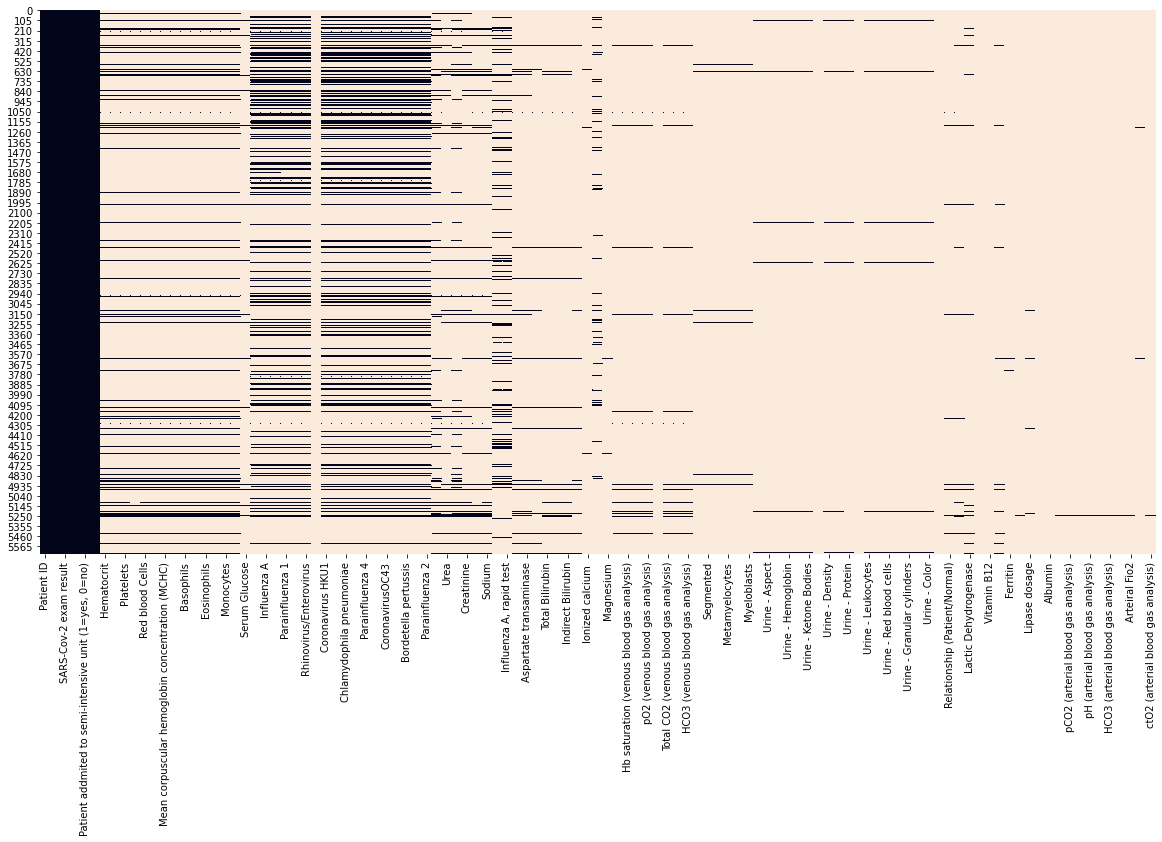

In [9]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.isna(), cbar=False)

On remarque à travers les zones blanches de ce tableau qu'il y a énormément de valeurs manquantes dans notre dataset.

In [10]:
#On veut observer le pourcentage des valeurs manquantes pour chaque variable, en ordre croissant
(data.isna().sum()*100/data.shape[0]).sort_values(ascending=True)

Patient ID                                                 0.000000
Patient age quantile                                       0.000000
SARS-Cov-2 exam result                                     0.000000
Patient addmited to regular ward (1=yes, 0=no)             0.000000
Patient addmited to semi-intensive unit (1=yes, 0=no)      0.000000
Patient addmited to intensive care unit (1=yes, 0=no)      0.000000
Influenza B                                               76.009922
Respiratory Syncytial Virus                               76.009922
Influenza A                                               76.009922
Rhinovirus/Enterovirus                                    76.045358
Inf A H1N1 2009                                           76.045358
CoronavirusOC43                                           76.045358
Coronavirus229E                                           76.045358
Parainfluenza 4                                           76.045358
Adenovirus                                      

<style>.couleur {
    color:rgb(245, 130, 130);
    font: 15px "Marker Felt", "Zapfino", cursive;}
</style>
Les colonnes <b class='couleur'>Patient ID, Patient age quantile, SARS-Cov-2 exam result,Patient addmited to regular ward (1=yes, 0=no), Patient addmited to semi-intensive unit (1=yes, 0=no) et Patient addmited to intensive care unit (1=yes, 0=no)</b> n'ont aucune valeur manquante. On sait d'ores et déjà qu'on va les garder, en tout cas, pour le moment.
Les autres variables quant à elles, ont au mois 76% de valeurs manquantes.

In [11]:
# Eliminons les colonnes ayant plus de 80% de valeurs manquantes

bad_columns = list(data.columns[(data.isna().sum()/data.shape[0] > 0.9)])

df.drop(bad_columns, axis=1, inplace=True)

In [12]:
df.head()

Patient ID  Patient age quantile SARS-Cov-2 exam result  \
0  44477f75e8169d2                    13               negative   
1  126e9dd13932f68                    17               negative   
2  a46b4402a0e5696                     8               negative   
3  f7d619a94f97c45                     5               negative   
4  d9e41465789c2b5                    15               negative   

   Patient addmited to regular ward (1=yes, 0=no)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Patient addmited to semi-intensive unit (1=yes, 0=no)  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   Patient addmited to intensive care unit (1=yes, 0=no)  Hematocrit  \
0                                                  0             NaN   
1                                                  0        0.236515   
2                                                  0             NaN   
3                                                  0             NaN   
4                                                  0             NaN   

   Hemoglobin  Platelets  Mean platelet volume   Red blood Cells  Lymphocytes  \
0         NaN        NaN                    NaN              NaN          NaN   
1    -0.02234  -0.517413               0.010677         0.102004     0.318366   
2         NaN        NaN                    NaN              NaN          NaN   
3         NaN        NaN                    NaN              NaN          NaN   
4         NaN        NaN                    NaN              NaN          NaN   

   Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  Basophils  \
0                                               NaN         NaN        NaN   
1                                          -0.95079    -0.09461  -0.223767   
2                                               NaN         NaN        NaN   
3                                               NaN         NaN        NaN   
4                                               NaN         NaN        NaN   

   Mean corpuscular hemoglobin (MCH)  Eosinophils  \
0                                NaN          NaN   
1                          -0.292269     1.482158   
2                                NaN          NaN   
3                                NaN          NaN   
4                                NaN          NaN   

   Mean corpuscular volume (MCV)  Monocytes  \
0                            NaN        NaN   
1                       0.166192   0.357547   
2                            NaN        NaN   
3                            NaN        NaN   
4                            NaN        NaN   

   Red blood cell distribution width (RDW) Respiratory Syncytial Virus  \
0                                      NaN                         NaN   
1                                -0.625073                not_detected   
2                                      NaN                         NaN   
3                                      NaN                         NaN   
4                                      NaN                not_detected   

    Influenza A   Influenza B Parainfluenza 1 CoronavirusNL63  \
0           NaN           NaN             NaN             NaN   
1  not_detected  not_detected    not_detected    not_detected   
2           NaN           NaN             NaN             NaN   
3           NaN           NaN             NaN             NaN   
4  not_detected  not_detected    not_detected    not_detected   

  Rhinovirus/Enterovirus Coronavirus HKU1 Parainfluenza 3  \
0                    NaN             

In [13]:
df.describe()

Patient age quantile  Patient addmited to regular ward (1=yes, 0=no)  \
count           5644.000000                                     5644.000000   
mean               9.318391                                        0.013997   
std                5.777903                                        0.117489   
min                0.000000                                        0.000000   
25%                4.000000                                        0.000000   
50%                9.000000                                        0.000000   
75%               14.000000                                        0.000000   
max               19.000000                                        1.000000   

       Patient addmited to semi-intensive unit (1=yes, 0=no)  \
count                                        5644.000000       
mean                                            0.008859       
std                                             0.093713       
min                                             0.000000       
25%                                             0.000000       
50%                                             0.000000       
75%                                             0.000000       
max                                             1.000000       

       Patient addmited to intensive care unit (1=yes, 0=no)    Hematocrit  \
count                                        5644.000000      6.030000e+02   
mean                                            0.007264     -2.186214e-09   
std                                             0.084929      1.000830e+00   
min                                             0.000000     -4.501420e+00   
25%                                             0.000000     -5.188074e-01   
50%                                             0.000000      5.340703e-02   
75%                                             0.000000      7.171751e-01   
max                                             1.000000      2.662704e+00   

         Hemoglobin     Platelets  Mean platelet volume   Red blood Cells  \
count  6.030000e+02  6.020000e+02           5.990000e+02     6.020000e+02   
mean  -1.601319e-08 -3.535004e-10           7.438142e-09     8.424447e-09   
std    1.000830e+00  1.000832e+00           1.000836e+00     1.000832e+00   
min   -4.345603e+00 -2.552426e+00          -2.457575e+00    -3.970608e+00   
25%   -5.862439e-01 -6.053457e-01          -6.624832e-01    -5.679496e-01   
50%    4.031596e-02 -1.217160e-01          -1.015171e-01     1.385207e-02   
75%    7.295320e-01  5.314981e-01           6.838353e-01     6.661759e-01   
max    2.671868e+00  9.532034e+00           3.713052e+00     3.645706e+00   

        Lymphocytes  Mean corpuscular hemoglobin concentration (MCHC)  \
count  6.020000e+02                                      6.020000e+02   
mean  -7.866736e-09                                      1.014863e-09   
std    1.000832e+00                                      1.000832e+00   
min   -1.865070e+00                                     -5.431808e+00   
25%   -7.307069e-01                                     -5.524761e-01   
50%   -1.426696e-02                                     -5.458523e-02   
75%    5.976919e-01                                      6.424628e-01   
max    3.764100e+00                                      3.331071e+00   

         Leukocytes     Basophils  Mean corpuscular hemoglobin (MCH)  \
count  6.020000e+02  6.020000e+02                       6.020000e+02   
mean   6.215833e-09 -6.633740e-09                      -3.453010e-09   
std    1.000832e+00  1.000832e+00                       1.000832e+00   
min   -2.020303e+00 -1.140144e+00                      -5.937604e+00   
25%   -6.372547e-01 -5.292256e-01                      -5.013556e-01   
50%   -2.128790e-01 -2.237665e-01                       1.259032e-01   
75%    4.542955e-01  3.871516e-01                       5.963475e-01   
max    4.522042e+00  1.107822e+01                       4.098546e+00   

        Eosino

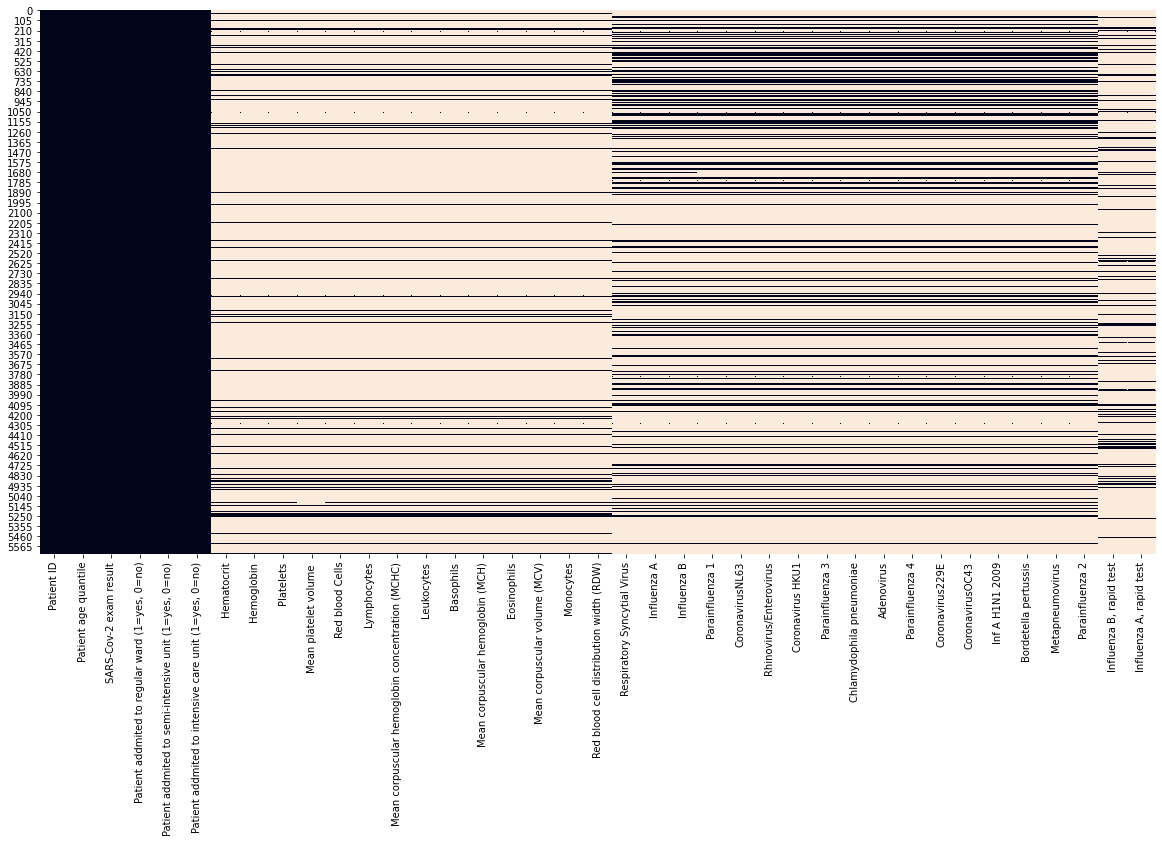

In [14]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.isna(), cbar=False)

C'est quand-même mieux qu'avant, yes!

In [15]:
#La colonne Patient ID elle aussi ne nous sert pas à grand chose 
#Je veux dire, que va-t-on faire de cette information ?
#On peut la retirer

df.drop('Patient ID', axis=1, inplace=True)
df.head()

Patient age quantile SARS-Cov-2 exam result  \
0                    13               negative   
1                    17               negative   
2                     8               negative   
3                     5               negative   
4                    15               negative   

   Patient addmited to regular ward (1=yes, 0=no)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Patient addmited to semi-intensive unit (1=yes, 0=no)  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   Patient addmited to intensive care unit (1=yes, 0=no)  Hematocrit  \
0                                                  0             NaN   
1                                                  0        0.236515   
2                                                  0             NaN   
3                                                  0             NaN   
4                                                  0             NaN   

   Hemoglobin  Platelets  Mean platelet volume   Red blood Cells  Lymphocytes  \
0         NaN        NaN                    NaN              NaN          NaN   
1    -0.02234  -0.517413               0.010677         0.102004     0.318366   
2         NaN        NaN                    NaN              NaN          NaN   
3         NaN        NaN                    NaN              NaN          NaN   
4         NaN        NaN                    NaN              NaN          NaN   

   Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  Basophils  \
0                                               NaN         NaN        NaN   
1                                          -0.95079    -0.09461  -0.223767   
2                                               NaN         NaN        NaN   
3                                               NaN         NaN        NaN   
4                                               NaN         NaN        NaN   

   Mean corpuscular hemoglobin (MCH)  Eosinophils  \
0                                NaN          NaN   
1                          -0.292269     1.482158   
2                                NaN          NaN   
3                                NaN          NaN   
4                                NaN          NaN   

   Mean corpuscular volume (MCV)  Monocytes  \
0                            NaN        NaN   
1                       0.166192   0.357547   
2                            NaN        NaN   
3                            NaN        NaN   
4                            NaN        NaN   

   Red blood cell distribution width (RDW) Respiratory Syncytial Virus  \
0                                      NaN                         NaN   
1                                -0.625073                not_detected   
2                                      NaN                         NaN   
3                                      NaN                         NaN   
4                                      NaN                not_detected   

    Influenza A   Influenza B Parainfluenza 1 CoronavirusNL63  \
0           NaN           NaN             NaN             NaN   
1  not_detected  not_detected    not_detected    not_detected   
2           NaN           NaN             NaN             NaN   
3           NaN           NaN             NaN             NaN   
4  not_detected  not_detected    not_detected    not_detected   

  Rhinovirus/Enterovirus Coronavirus HKU1 Parainfluenza 3  \
0                    NaN              NaN             NaN   
1               detected     not_detected    not_detected   
2           

<h5>Analysons notre target</h5>

In [16]:
df['SARS-Cov-2 exam result'].value_counts(normalize=True)

negative    0.901134
positive    0.098866
Name: SARS-Cov-2 exam result, dtype: float64

La target a 90% de tests négatifs et quasiment 10% de tests positifs

<h5>Analyse des variables quantitatives</h5>

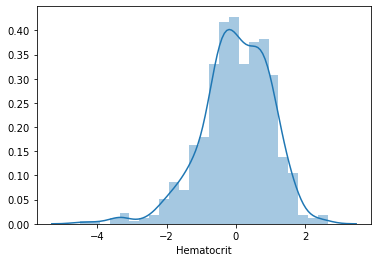

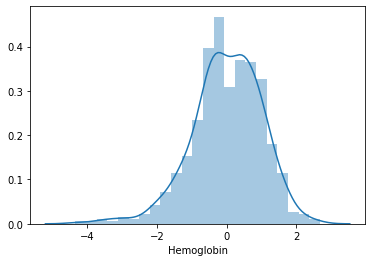

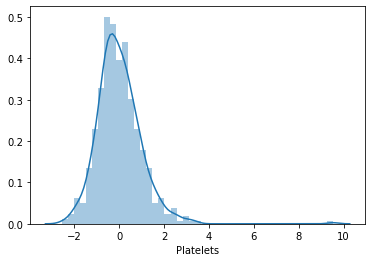

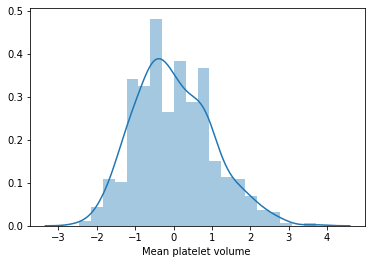

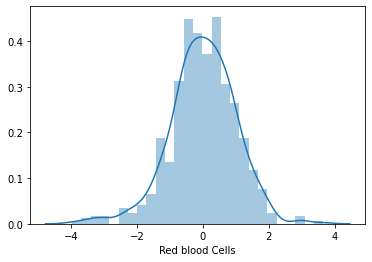

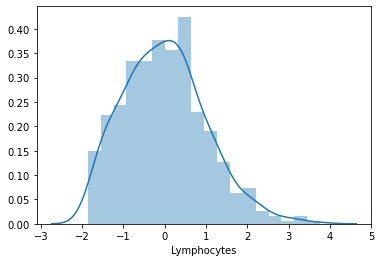

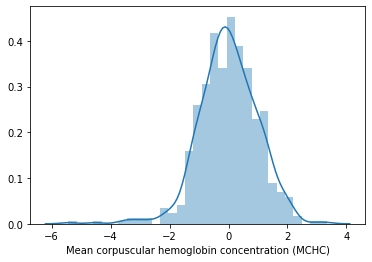

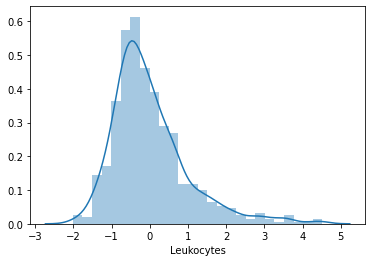

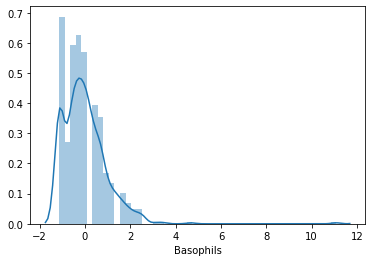

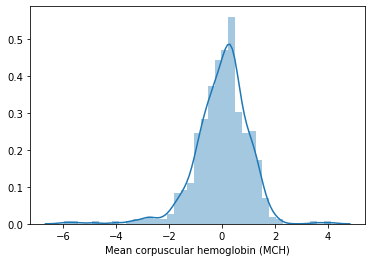

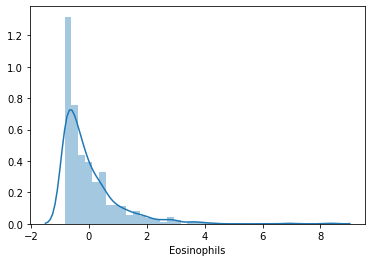

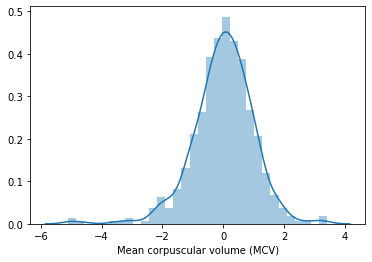

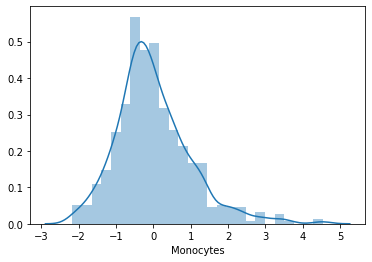

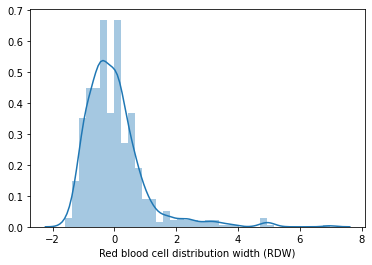

In [17]:
for col in df.select_dtypes('float'):
    plt.figure()
    sns.distplot(df[col])

Elles sont preque toutes centrées en zéro et ont un écart type autour de 1 --> Normalisées

In [18]:
df['Patient age quantile'].value_counts()

11    380
4     366
9     359
0     334
7     319
2     315
13    313
14    299
5     294
6     281
16    279
19    275
15    269
17    263
18    259
3     251
1     234
12    197
10    190
8     167
Name: Patient age quantile, dtype: int64

<h5>Analysons les variables qualitatives</h5>

In [84]:
for col in df.select_dtypes('object'):
    print(f'{col :-<30} {df[col].unique()}')

SARS-Cov-2 exam result-------- ['negative' 'positive']
Respiratory Syncytial Virus--- [nan 'not_detected' 'detected']
Influenza A------------------- [nan 'not_detected' 'detected']
Influenza B------------------- [nan 'not_detected' 'detected']
Parainfluenza 1--------------- [nan 'not_detected' 'detected']
CoronavirusNL63--------------- [nan 'not_detected' 'detected']
Rhinovirus/Enterovirus-------- [nan 'detected' 'not_detected']
Coronavirus HKU1-------------- [nan 'not_detected' 'detected']
Parainfluenza 3--------------- [nan 'not_detected' 'detected']
Chlamydophila pneumoniae------ [nan 'not_detected' 'detected']
Adenovirus-------------------- [nan 'not_detected' 'detected']
Parainfluenza 4--------------- [nan 'not_detected' 'detected']
Coronavirus229E--------------- [nan 'not_detected' 'detected']
CoronavirusOC43--------------- [nan 'not_detected' 'detected']
Inf A H1N1 2009--------------- [nan 'not_detected' 'detected']
Bordetella pertussis---------- [nan 'not_detected' 'detected']


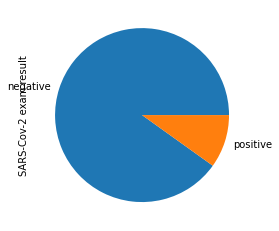

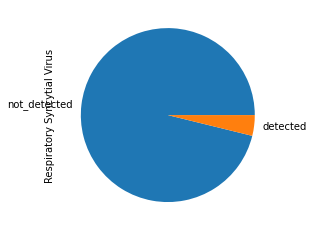

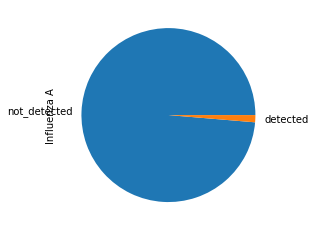

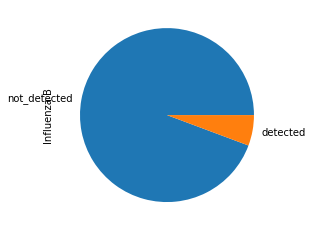

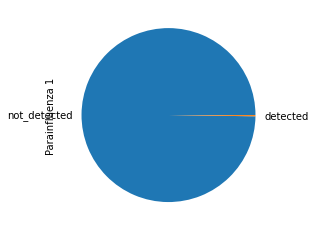

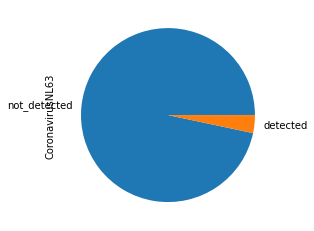

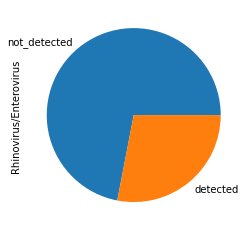

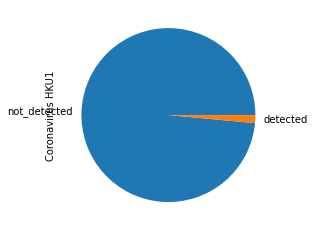

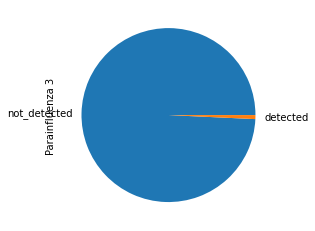

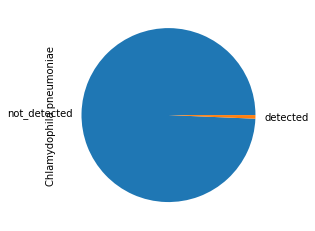

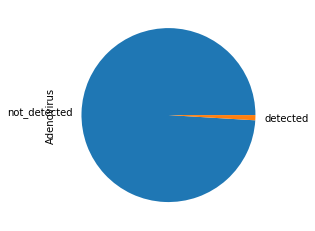

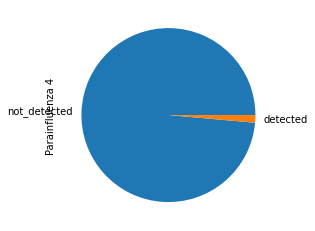

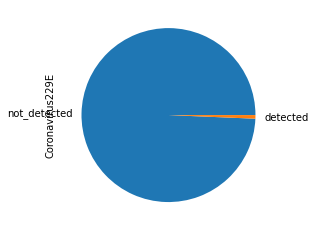

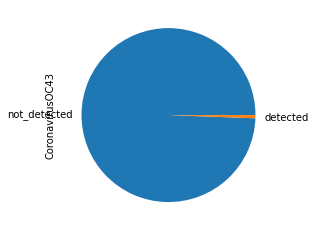

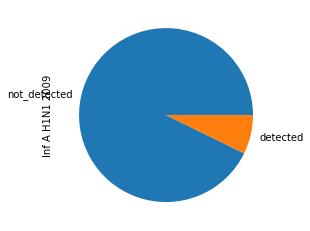

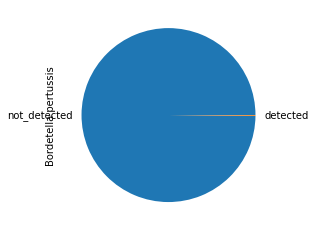

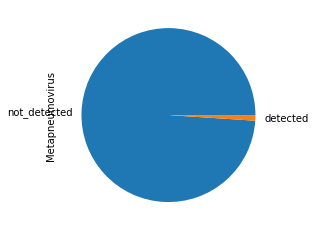

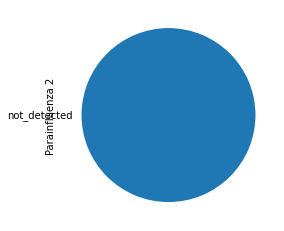

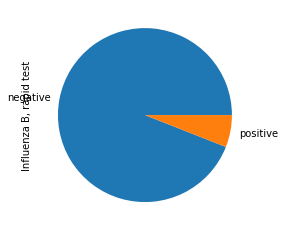

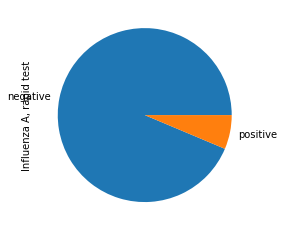

In [19]:
for col in df.select_dtypes('object'):
    plt.figure()
    df[col].value_counts().plot.pie()

<h5>Visualisons à présent les relations entre les variables et la target</h5>

In [20]:
# Créoons des sous-ensembles positifs et négatifs

positive_df = df[df['SARS-Cov-2 exam result'] == 'positive']
negative_df = df[df['SARS-Cov-2 exam result'] == 'negative']

In [21]:
# Créons les catégories des variables de classe Blood et Viral
missing_rate = df.isna().sum()/df.shape[0]

#Observons quelles colonnes ont des valeurs manquantes comprises entre 88% et 90%
blood_columns = df.columns[(missing_rate > 0.88) & (missing_rate < 0.9)]
viral_colums = df.columns[(missing_rate > 0.75) & (missing_rate < 0.88)]

<h5>Relation Target/Blood</h5>

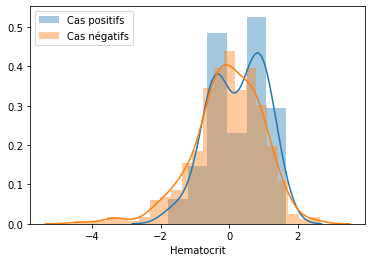

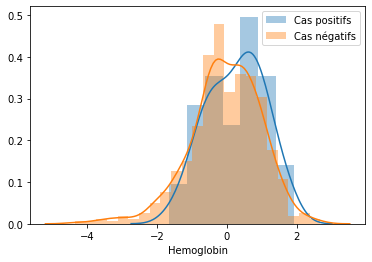

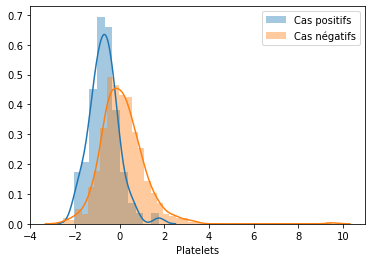

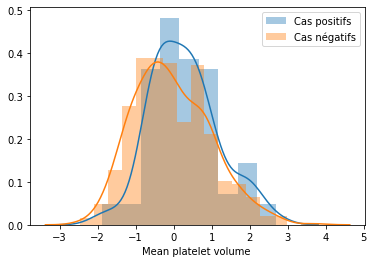

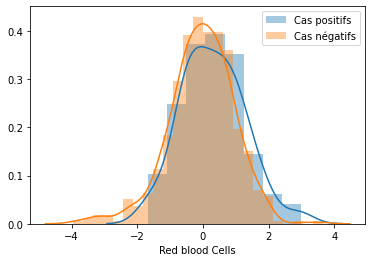

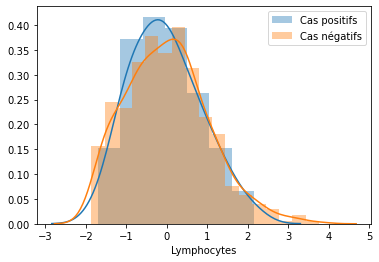

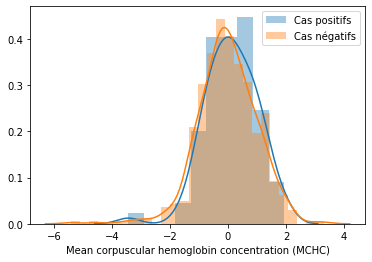

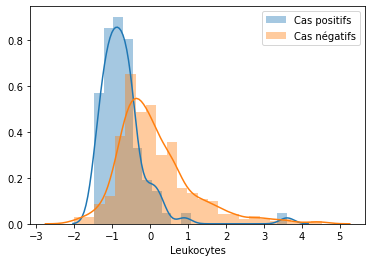

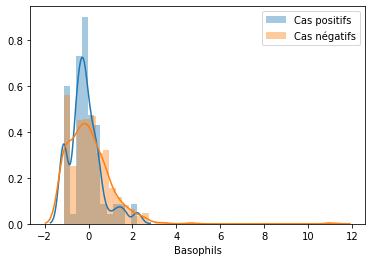

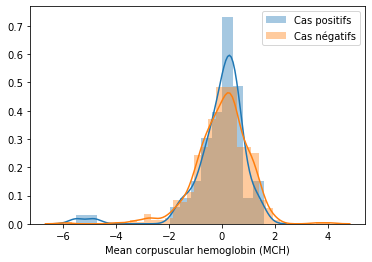

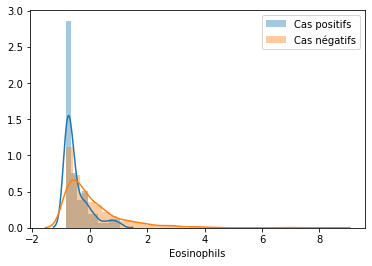

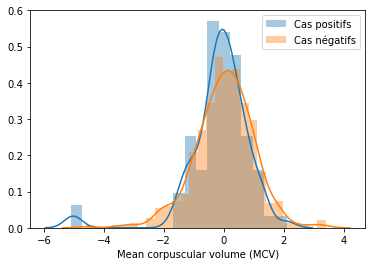

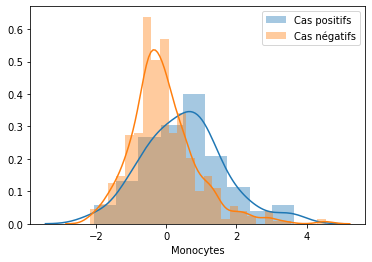

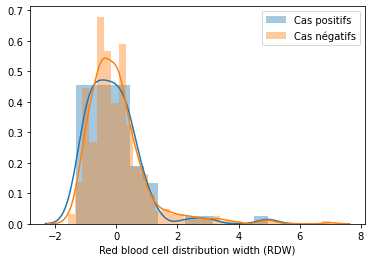

In [22]:
for col in blood_columns:
    plt.figure()
    sns.distplot(positive_df[col], label='Cas positifs') #Pour afficher tous les tests sanguins qui ont donné un test positif
    sns.distplot(negative_df[col], label='Cas négatifs') #Pour afficher tous les tests sanguins qui ont donné un test négatif
    plt.legend()

On remarque que les variables Monocytes, Leukocytes et Platelets n'ont pas vraiment les même distributions pour les tests positifs et negatifs. Elles semblent liées au Covid-19.

<h5>Visualisons la relation entre la target et l'age</h5>

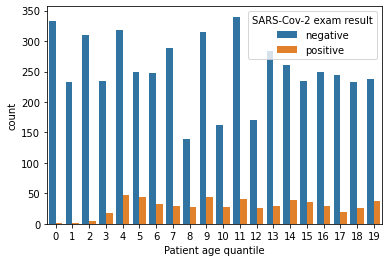

In [23]:
sns.countplot(x = 'Patient age quantile', hue='SARS-Cov-2 exam result', data=df)

On remarque que les quantiles 1, 2 et 3 sont plus susceptibles à être négatifs que positifs.

<h5>Relation Target/Viral

In [24]:
# Pour comparer deux variables quantitatives on utilise la crosstab de pandas

pd.crosstab(df['SARS-Cov-2 exam result'], df['Influenza A'])

Influenza A             detected  not_detected
SARS-Cov-2 exam result                        
negative                      18          1224
positive                       0           112

Remarque:<br>
--> 18 personnes sont positifs à l'Influenza A et négatifs au Covid-19<br>
--> Aucun patient n'a à la fois le covid et l'Influenza A<br>
--> 1224 sont négatifs aux deux<br>
--> 112 personnes sont positifs au covid et négatifs à l'Influenza A

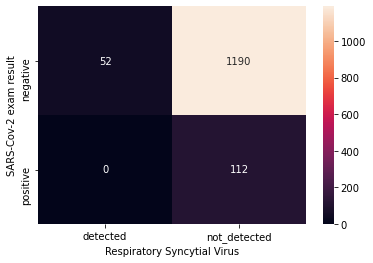

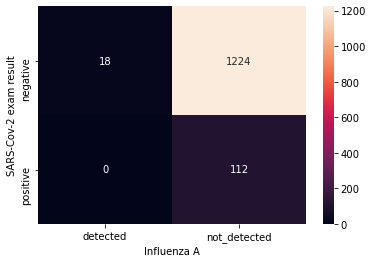

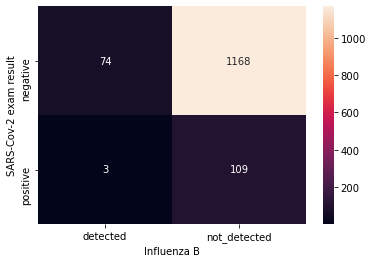

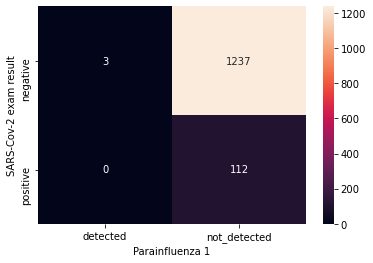

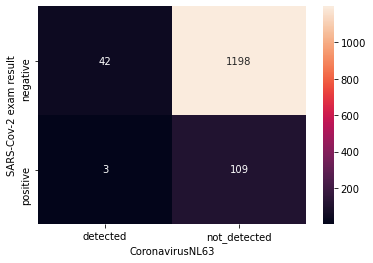

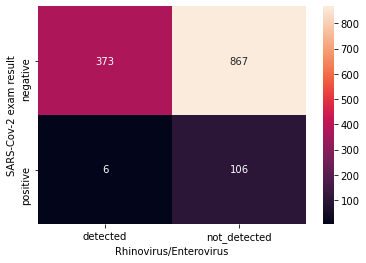

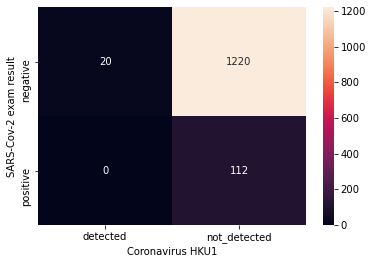

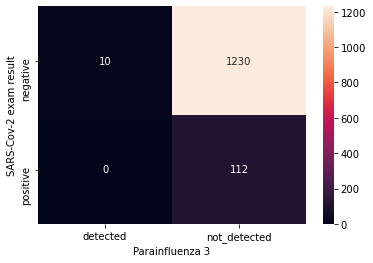

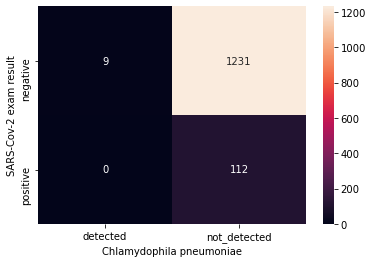

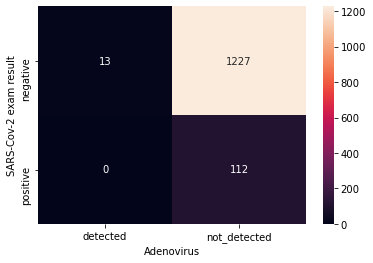

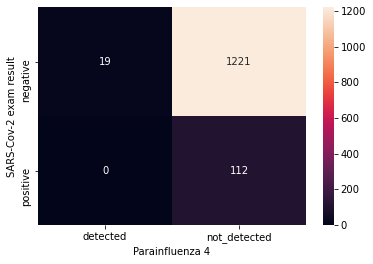

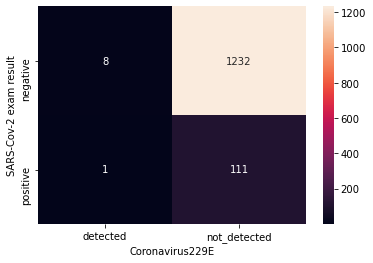

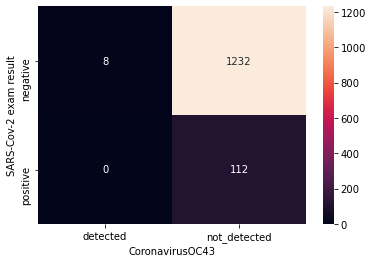

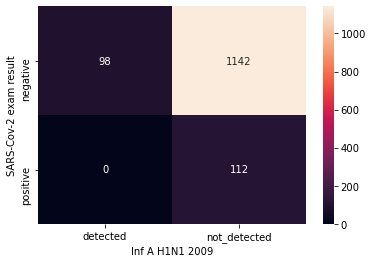

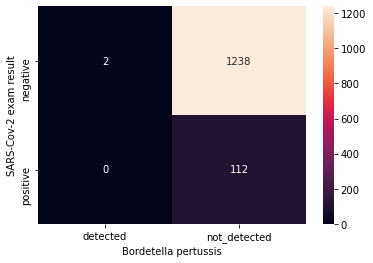

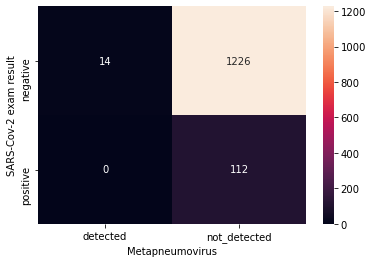

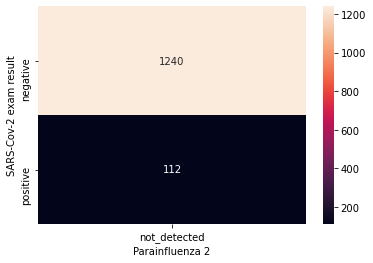

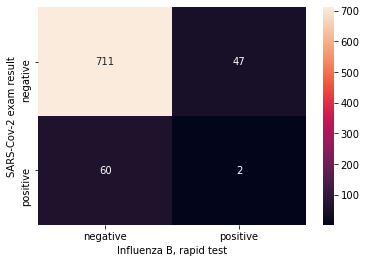

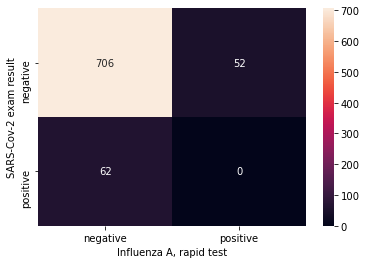

In [25]:
for col in viral_colums:
    plt.figure()
    sns.heatmap(pd.crosstab(df['SARS-Cov-2 exam result'], df[col]), annot=True, fmt='d')

Remarque:<br>
- En général selon ces données il est rare de trouver un patient ayant deux virus à la fois.<br>
Il y a énormément de patients qui sont positifs au Rhinovirus/Enterovirus mais négatifs au Corona virus. C'est une hypothèse à tester(il se pourrait que nous ayons les données d'une region frappée par le Rhinovirus).
- La variable Parainfluenza 2 ne contient qu'une seule valeur, elle est à rejeter.

# Analyse plus détaillée <br>
- *Relation variables/variables:*
    - blood_df/blood_df : Certaines variables sont très corrélées(+90% de corrélation): à surveiller<br>
    - blood_df/age : Le coefficient de corrélation le plus élevé atteint à peine 28%, c'est vraiment faible. On ne peut pas dire que l'âge ait une influence sur le taux sanguin par exemple.<br>
    - viral/viral<br>
    - relation maladie/blood_df<br>
    - relation hospitalisation/est malade<br>
    - relation hospitalisation/blood_df<br>
- *NaN analyse*: Remarque:
    - si on élimine les valeurs manquantes de blood il nous reste environ 600 données.<br>
    - si on élimines les valeurs les NaN de viral il nous reste environ 1350 données<br>
**Hypothèse nulle H0**
1. Les individus positifs au covid ont des taux de Leukocytes, Monocytes et Platelets significativement différents de ceux qui sont négatifs.
2. Les individus atteints d'une quelconque maladie ont des taux significativement différents.

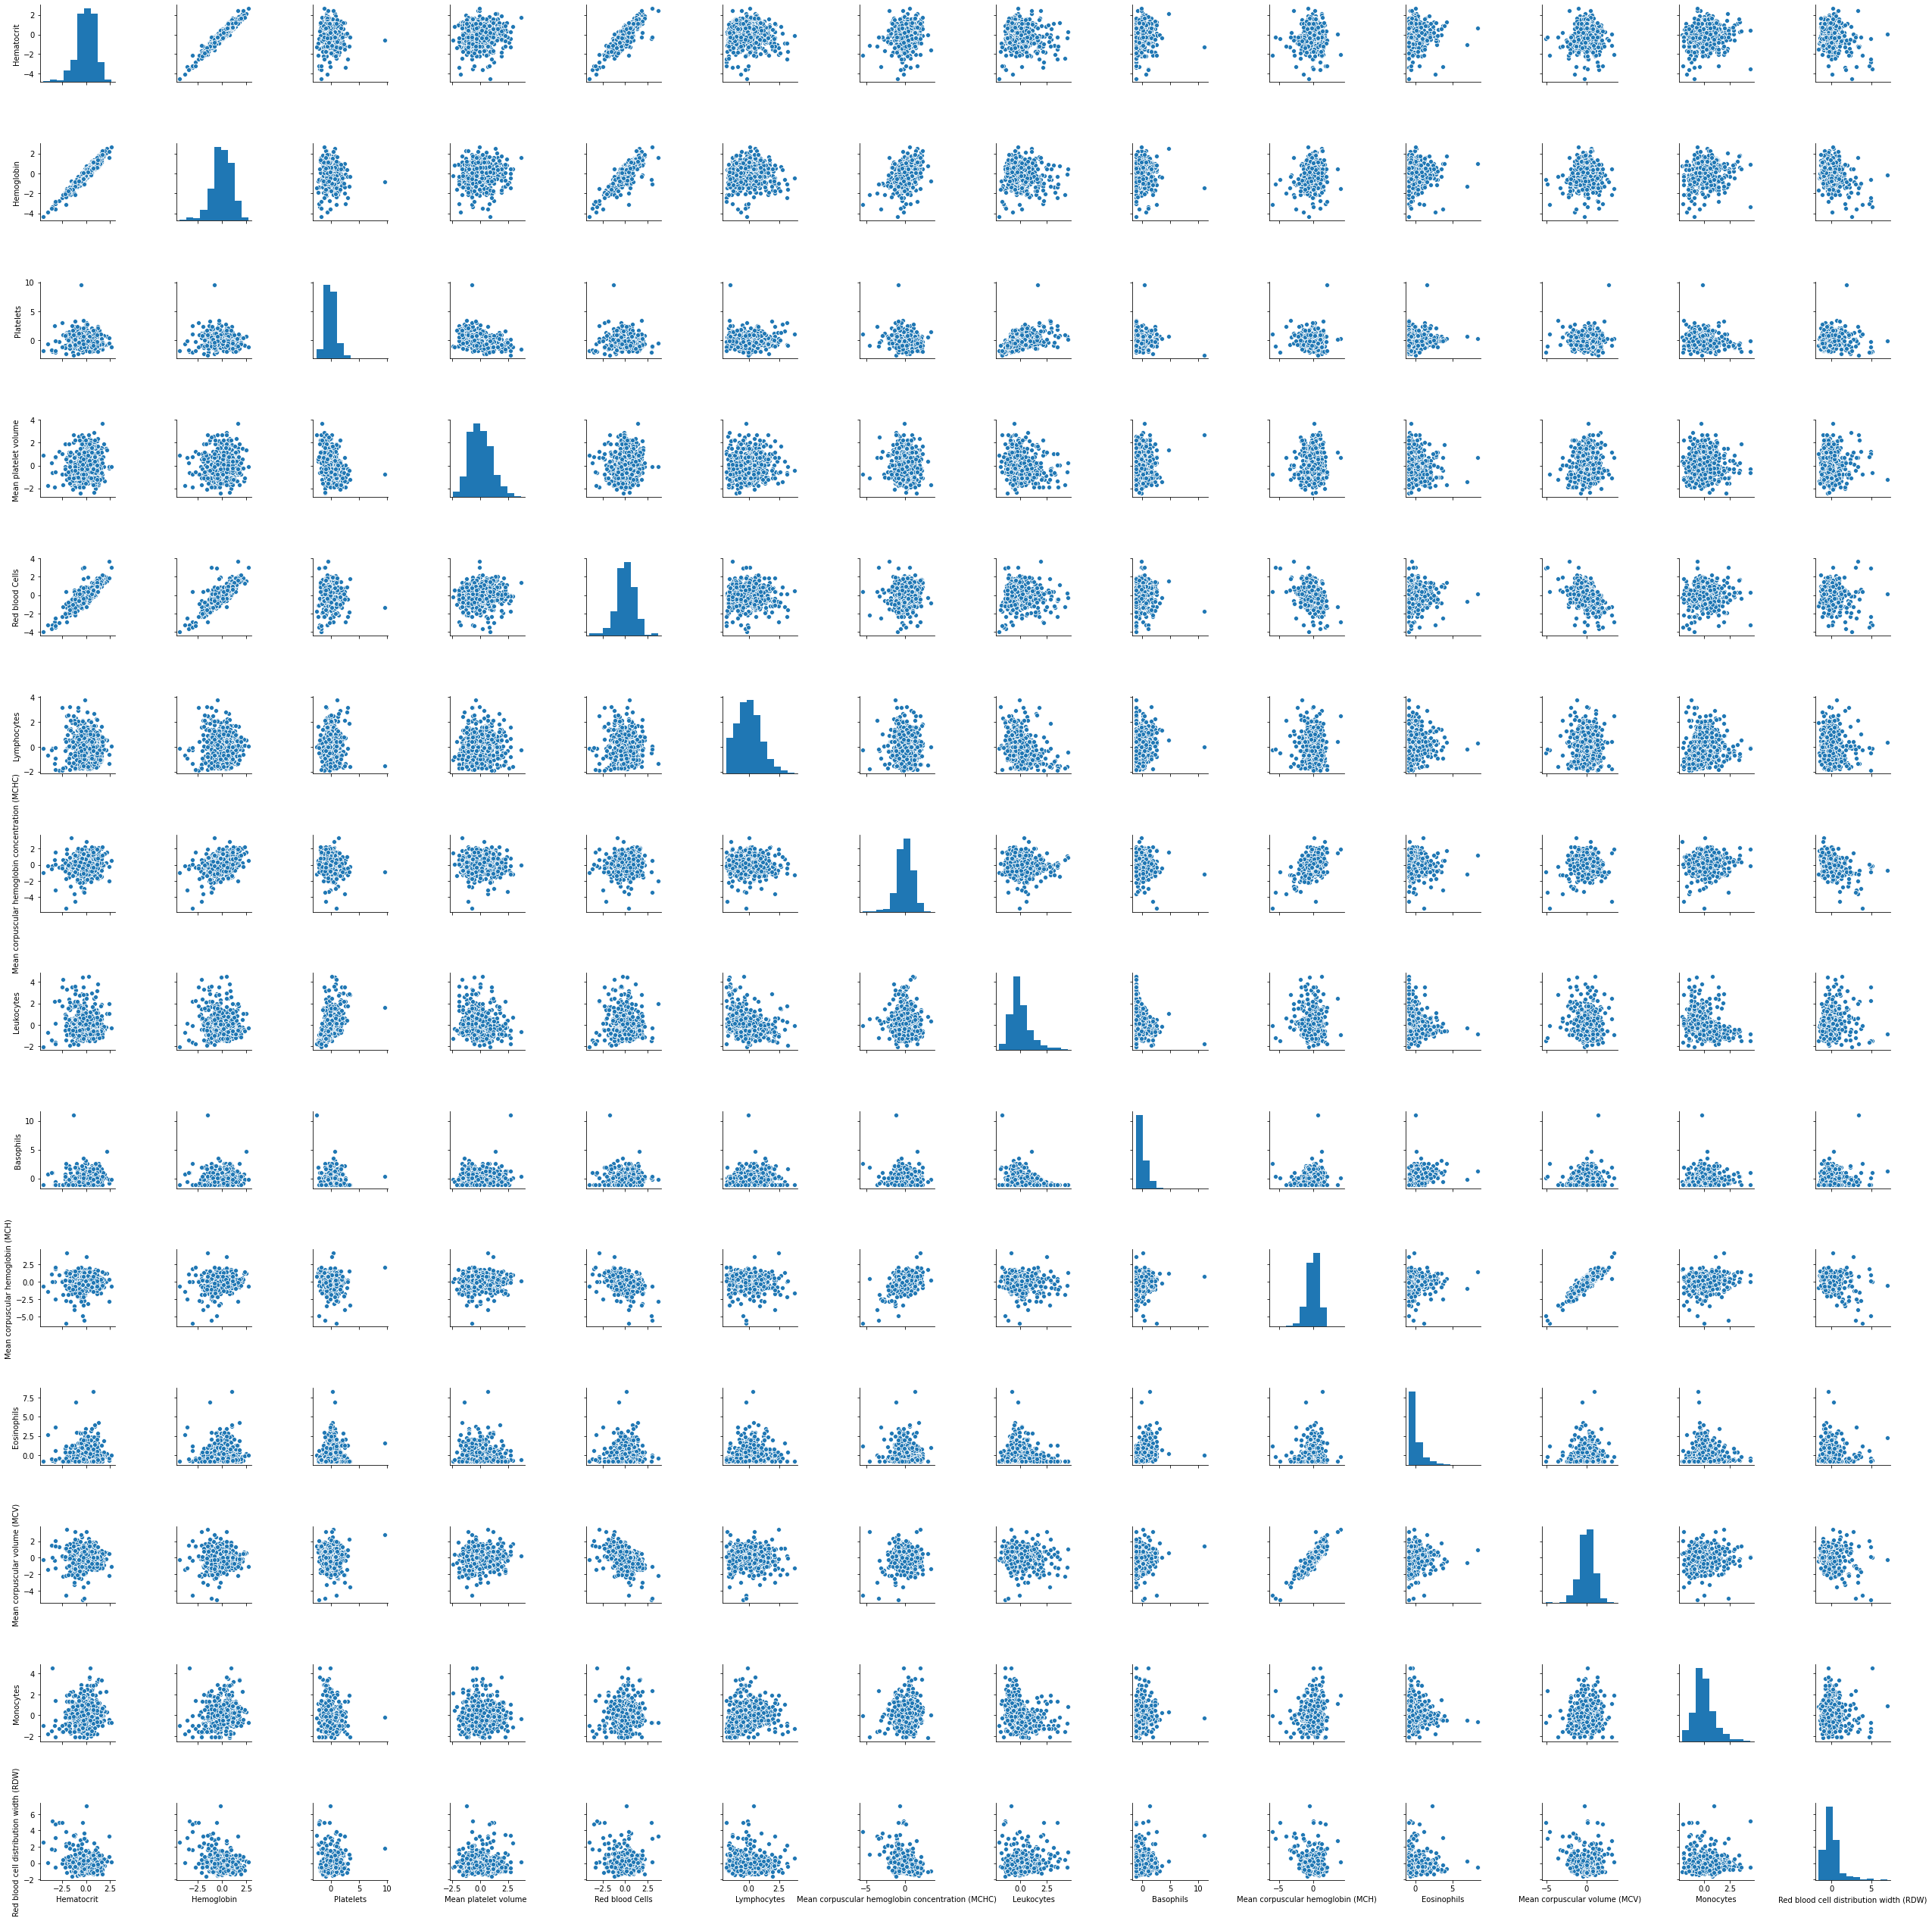

In [96]:
#Voyons les relations entre les taux sanguins

sns.pairplot(df[blood_columns])

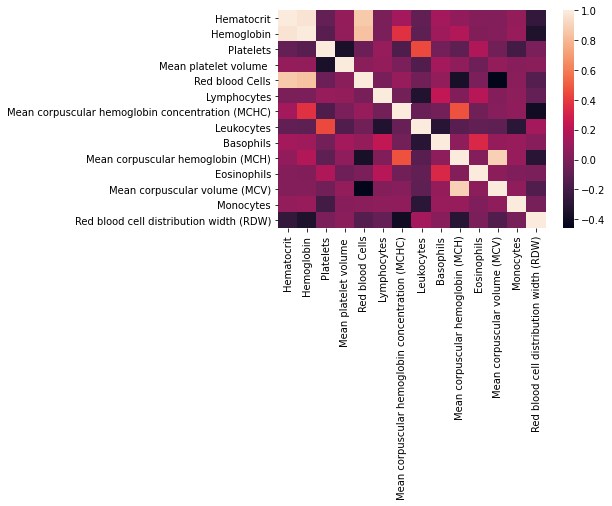

In [26]:
sns.heatmap(df[blood_columns].corr())

Certaines variables sont très corrélées(+90% de corrélation): à surveiller

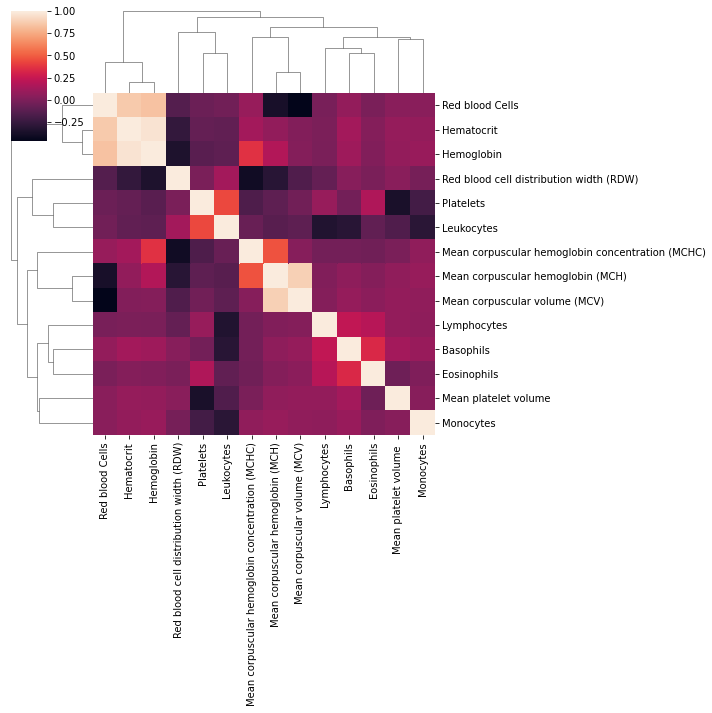

In [27]:
sns.clustermap(df[blood_columns].corr())

Auto clustering des variables les plus corrélées

<ipython-input-28-6aa58157a0ac>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/emman/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
<ipython-input-28-6aa58157a0ac>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_

<Figure size 432x288 with 0 Axes>

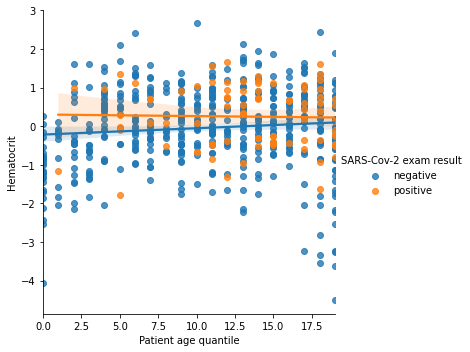

<Figure size 432x288 with 0 Axes>

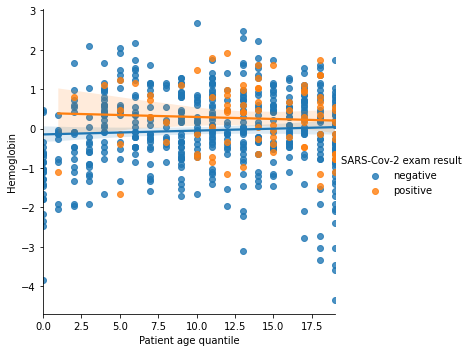

<Figure size 432x288 with 0 Axes>

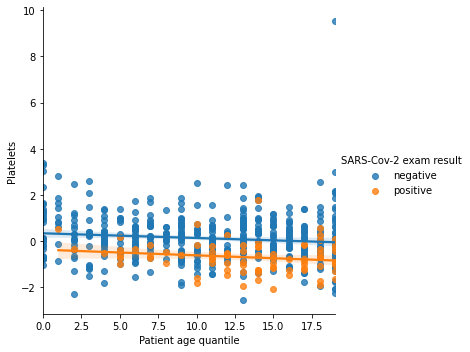

<Figure size 432x288 with 0 Axes>

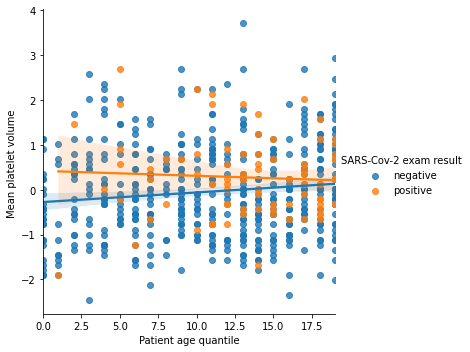

<Figure size 432x288 with 0 Axes>

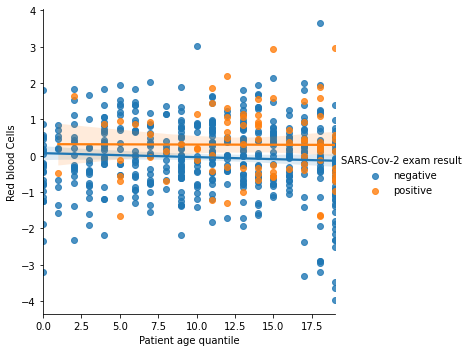

<Figure size 432x288 with 0 Axes>

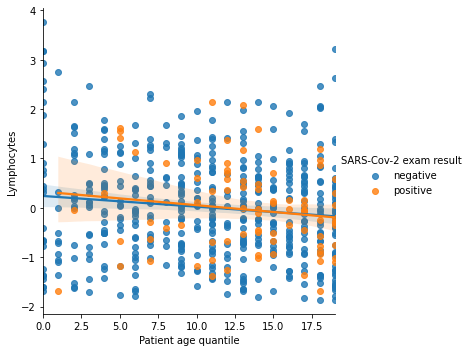

<Figure size 432x288 with 0 Axes>

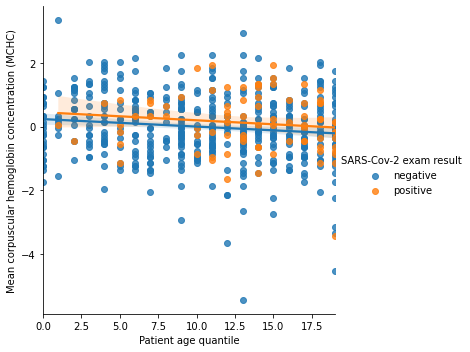

<Figure size 432x288 with 0 Axes>

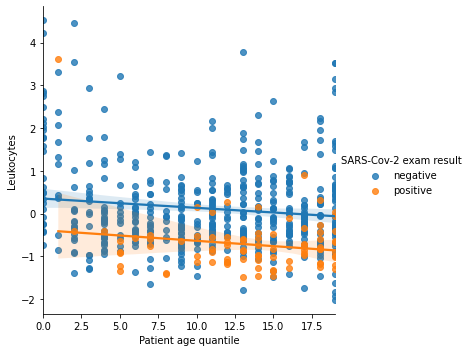

<Figure size 432x288 with 0 Axes>

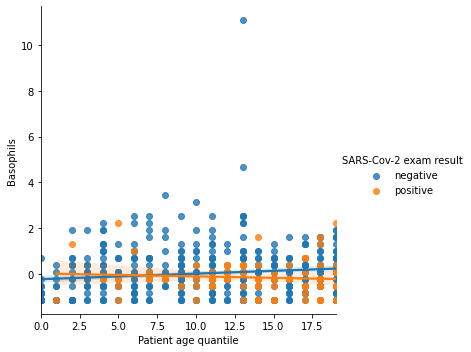

<Figure size 432x288 with 0 Axes>

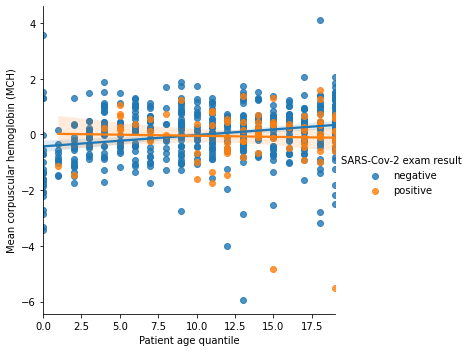

<Figure size 432x288 with 0 Axes>

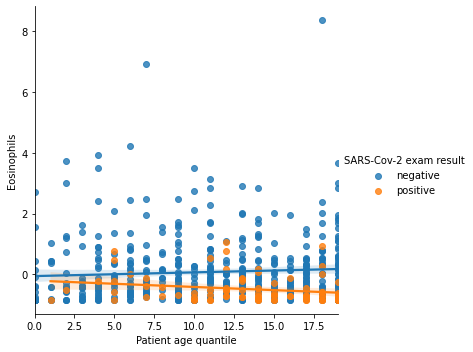

<Figure size 432x288 with 0 Axes>

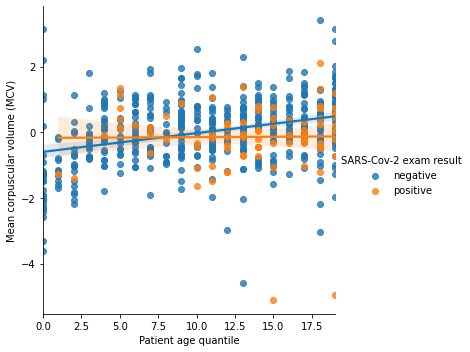

<Figure size 432x288 with 0 Axes>

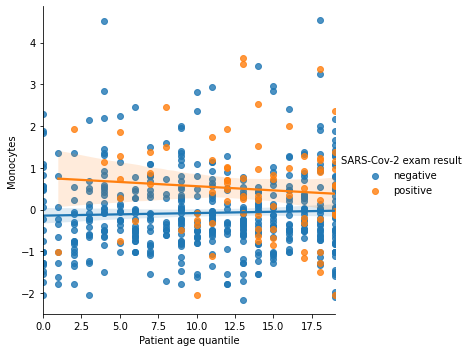

<Figure size 432x288 with 0 Axes>

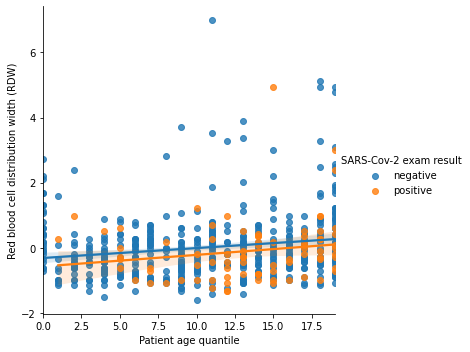

In [28]:
#Visualisons la relation entre le taux sanguin et l'âge de l'individu

for col in blood_columns:
    plt.figure()
    sns.lmplot(x='Patient age quantile', y=col, hue='SARS-Cov-2 exam result', data=df)

In [29]:
df.corr()['Patient age quantile'].sort_values()

Leukocytes                                              -0.166386
Platelets                                               -0.158683
Lymphocytes                                             -0.125935
Mean corpuscular hemoglobin concentration (MCHC)        -0.124671
Red blood Cells                                         -0.037510
Patient addmited to intensive care unit (1=yes, 0=no)   -0.035772
Patient addmited to semi-intensive unit (1=yes, 0=no)    0.015736
Eosinophils                                              0.022085
Patient addmited to regular ward (1=yes, 0=no)           0.046166
Monocytes                                                0.050962
Hemoglobin                                               0.060320
Hematocrit                                               0.096808
Basophils                                                0.107525
Mean platelet volume                                     0.119449
Red blood cell distribution width (RDW)                  0.166429
Mean corpu

Le coefficient de corrélation le plus élevé atteint à peine 28%, c'est vraiment faible. On ne peut pas dire que l'âge ait une influence sur le taux sanguin par exemple.

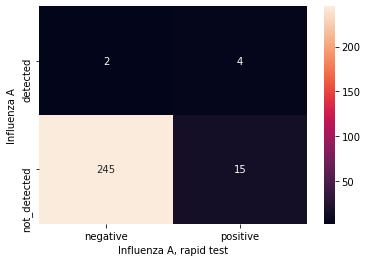

In [30]:
# Visualisons les variables Influenza et leurs rapid test

sns.heatmap(pd.crosstab(df['Influenza A'], df['Influenza A, rapid test']), annot=True, fmt='d')

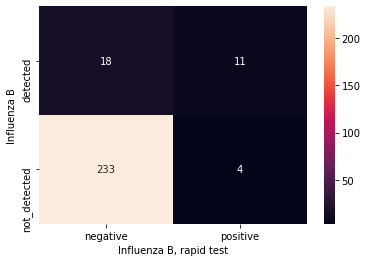

In [31]:
sns.heatmap(pd.crosstab(df['Influenza B'], df['Influenza B, rapid test']), annot=True, fmt='d')

Pourquoi les tests rapides donnent des resultats très différents des test en soi ?

Sur internet il est reconnu que les tests rapides de Influenza A et B sont très peu fiables.

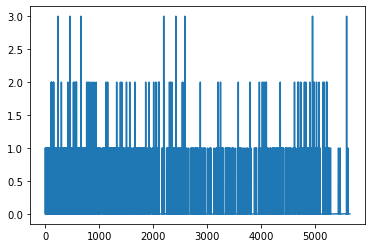

In [32]:
#On va créer une colonne "est malade" contenant tous les patients selon qu'ils soient malades(1) ou non(0)

plt.plot(np.sum(df[viral_colums[:-2]] == 'detected', axis=1))

In [33]:
df['est malade'] = np.sum(df[viral_colums[:-2]] == 'detected', axis=1) > 0
df.head()

Patient age quantile SARS-Cov-2 exam result  \
0                    13               negative   
1                    17               negative   
2                     8               negative   
3                     5               negative   
4                    15               negative   

   Patient addmited to regular ward (1=yes, 0=no)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Patient addmited to semi-intensive unit (1=yes, 0=no)  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   Patient addmited to intensive care unit (1=yes, 0=no)  Hematocrit  \
0                                                  0             NaN   
1                                                  0        0.236515   
2                                                  0             NaN   
3                                                  0             NaN   
4                                                  0             NaN   

   Hemoglobin  Platelets  Mean platelet volume   Red blood Cells  Lymphocytes  \
0         NaN        NaN                    NaN              NaN          NaN   
1    -0.02234  -0.517413               0.010677         0.102004     0.318366   
2         NaN        NaN                    NaN              NaN          NaN   
3         NaN        NaN                    NaN              NaN          NaN   
4         NaN        NaN                    NaN              NaN          NaN   

   Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  Basophils  \
0                                               NaN         NaN        NaN   
1                                          -0.95079    -0.09461  -0.223767   
2                                               NaN         NaN        NaN   
3                                               NaN         NaN        NaN   
4                                               NaN         NaN        NaN   

   Mean corpuscular hemoglobin (MCH)  Eosinophils  \
0                                NaN          NaN   
1                          -0.292269     1.482158   
2                                NaN          NaN   
3                                NaN          NaN   
4                                NaN          NaN   

   Mean corpuscular volume (MCV)  Monocytes  \
0                            NaN        NaN   
1                       0.166192   0.357547   
2                            NaN        NaN   
3                            NaN        NaN   
4                            NaN        NaN   

   Red blood cell distribution width (RDW) Respiratory Syncytial Virus  \
0                                      NaN                         NaN   
1                                -0.625073                not_detected   
2                                      NaN                         NaN   
3                                      NaN                         NaN   
4                                      NaN                not_detected   

    Influenza A   Influenza B Parainfluenza 1 CoronavirusNL63  \
0           NaN           NaN             NaN             NaN   
1  not_detected  not_detected    not_detected    not_detected   
2           NaN           NaN             NaN             NaN   
3           NaN           NaN             NaN             NaN   
4  not_detected  not_detected    not_detected    not_detected   

  Rhinovirus/Enterovirus Coronavirus HKU1 Parainfluenza 3  \
0                    NaN              NaN             NaN   
1               detected     not_detected    not_detected   
2           

In [34]:
malade_df = df[df['est malade'] == True]
non_malade_df = df[df['est malade'] == False]

print(malade_df.shape, non_malade_df.shape)

(692, 39) (4952, 39)


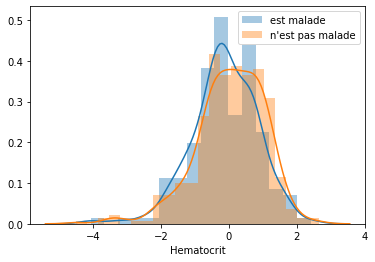

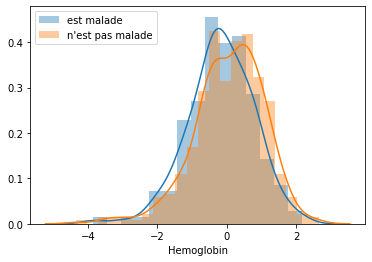

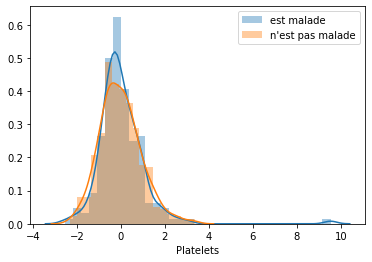

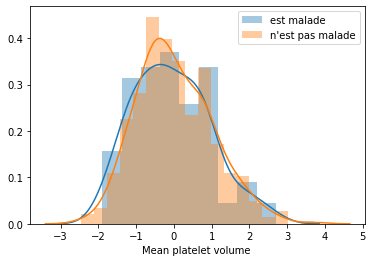

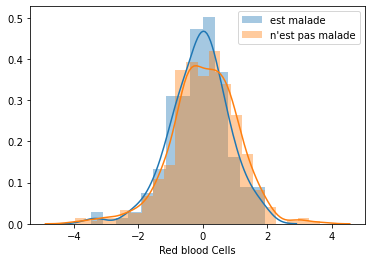

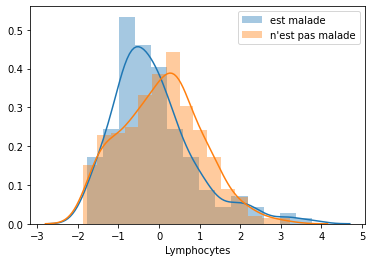

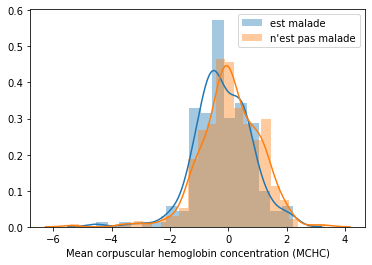

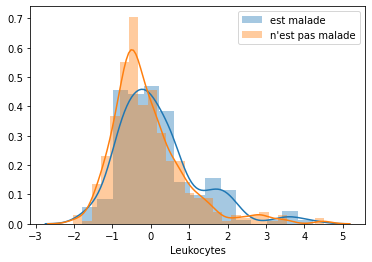

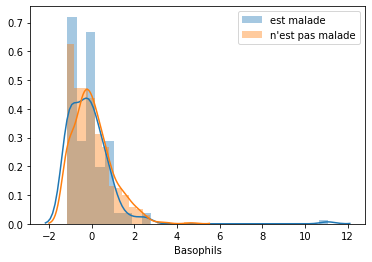

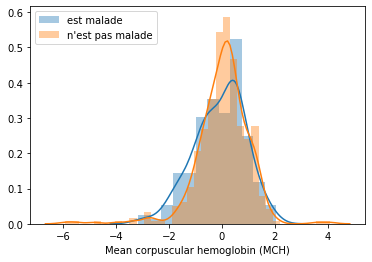

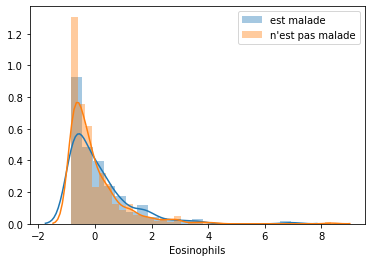

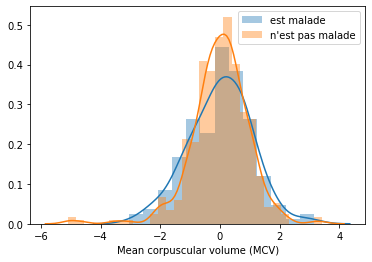

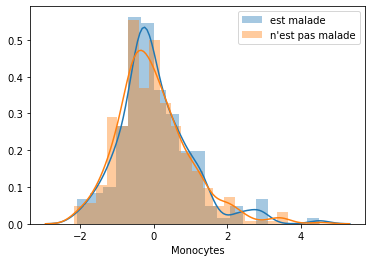

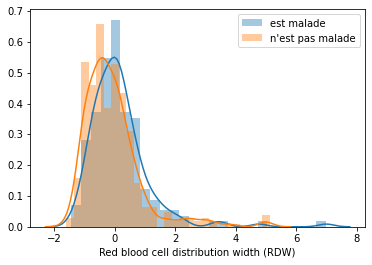

In [35]:
for col in blood_columns:
    plt.figure()
    sns.distplot(malade_df[col], label='est malade')
    sns.distplot(non_malade_df[col], label="n'est pas malade")
    plt.legend()

On peut observer que les taux sanguins entre maladies et covid-19 sont différents

In [129]:
df.columns.sort_values()

Index(['Adenovirus', 'Basophils', 'Bordetella pertussis',
       'Chlamydophila pneumoniae', 'Coronavirus HKU1', 'Coronavirus229E',
       'CoronavirusNL63', 'CoronavirusOC43', 'Eosinophils', 'Hematocrit',
       'Hemoglobin', 'Inf A H1N1 2009', 'Influenza A',
       'Influenza A, rapid test', 'Influenza B', 'Influenza B, rapid test',
       'Leukocytes', 'Lymphocytes', 'Mean corpuscular hemoglobin (MCH)',
       'Mean corpuscular hemoglobin concentration (MCHC)',
       'Mean corpuscular volume (MCV)', 'Mean platelet volume ',
       'Metapneumovirus', 'Monocytes', 'Parainfluenza 1', 'Parainfluenza 2',
       'Parainfluenza 3', 'Parainfluenza 4',
       'Patient addmited to intensive care unit (1=yes, 0=no)',
       'Patient addmited to regular ward (1=yes, 0=no)',
       'Patient addmited to semi-intensive unit (1=yes, 0=no)',
       'Patient age quantile', 'Platelets', 'Red blood Cells',
       'Red blood cell distribution width (RDW)',
       'Respiratory Syncytial Virus', 'Rhinovi

In [36]:
def hospitalisation(df):
    if df['Patient addmited to regular ward (1=yes, 0=no)'] == 1:
        return 'surveillance'
    elif df['Patient addmited to semi-intensive unit (1=yes, 0=no)'] == 1:
        return 'soins semi-intensifs'
    elif df['Patient addmited to intensive care unit (1=yes, 0=no)'] ==1:
        return 'soins intensifs'
    else:
        return 'inconnu'

In [37]:
df['statut'] = df.apply(hospitalisation, axis=1)
df.head()

Patient age quantile SARS-Cov-2 exam result  \
0                    13               negative   
1                    17               negative   
2                     8               negative   
3                     5               negative   
4                    15               negative   

   Patient addmited to regular ward (1=yes, 0=no)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Patient addmited to semi-intensive unit (1=yes, 0=no)  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   Patient addmited to intensive care unit (1=yes, 0=no)  Hematocrit  \
0                                                  0             NaN   
1                                                  0        0.236515   
2                                                  0             NaN   
3                                                  0             NaN   
4                                                  0             NaN   

   Hemoglobin  Platelets  Mean platelet volume   Red blood Cells  Lymphocytes  \
0         NaN        NaN                    NaN              NaN          NaN   
1    -0.02234  -0.517413               0.010677         0.102004     0.318366   
2         NaN        NaN                    NaN              NaN          NaN   
3         NaN        NaN                    NaN              NaN          NaN   
4         NaN        NaN                    NaN              NaN          NaN   

   Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  Basophils  \
0                                               NaN         NaN        NaN   
1                                          -0.95079    -0.09461  -0.223767   
2                                               NaN         NaN        NaN   
3                                               NaN         NaN        NaN   
4                                               NaN         NaN        NaN   

   Mean corpuscular hemoglobin (MCH)  Eosinophils  \
0                                NaN          NaN   
1                          -0.292269     1.482158   
2                                NaN          NaN   
3                                NaN          NaN   
4                                NaN          NaN   

   Mean corpuscular volume (MCV)  Monocytes  \
0                            NaN        NaN   
1                       0.166192   0.357547   
2                            NaN        NaN   
3                            NaN        NaN   
4                            NaN        NaN   

   Red blood cell distribution width (RDW) Respiratory Syncytial Virus  \
0                                      NaN                         NaN   
1                                -0.625073                not_detected   
2                                      NaN                         NaN   
3                                      NaN                         NaN   
4                                      NaN                not_detected   

    Influenza A   Influenza B Parainfluenza 1 CoronavirusNL63  \
0           NaN           NaN             NaN             NaN   
1  not_detected  not_detected    not_detected    not_detected   
2           NaN           NaN             NaN             NaN   
3           NaN           NaN             NaN             NaN   
4  not_detected  not_detected    not_detected    not_detected   

  Rhinovirus/Enterovirus Coronavirus HKU1 Parainfluenza 3  \
0                    NaN              NaN             NaN   
1               detected     not_detected    not_detected   
2           

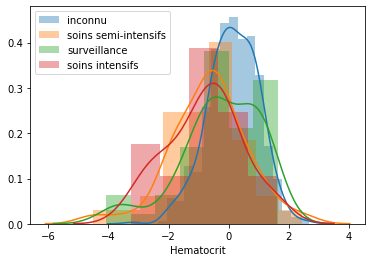

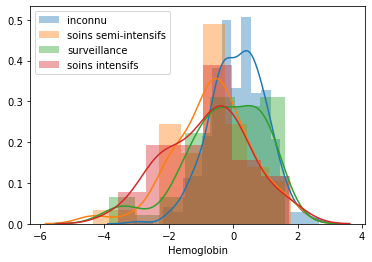

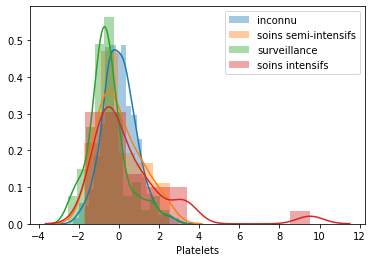

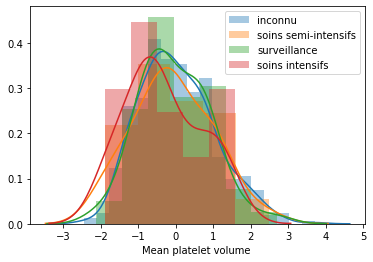

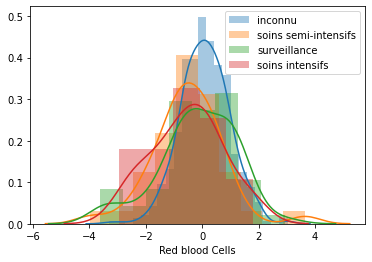

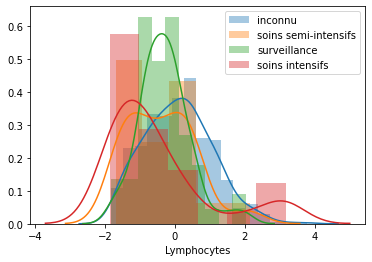

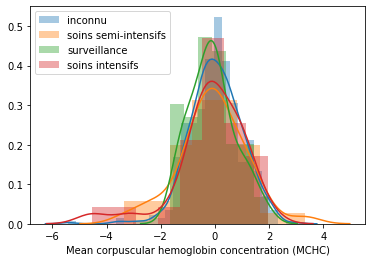

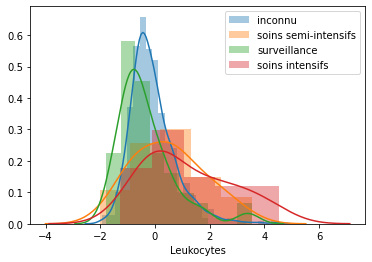

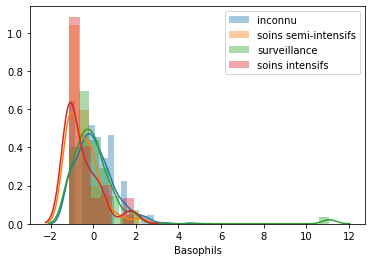

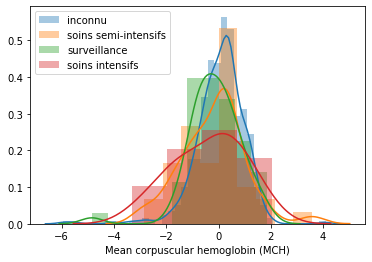

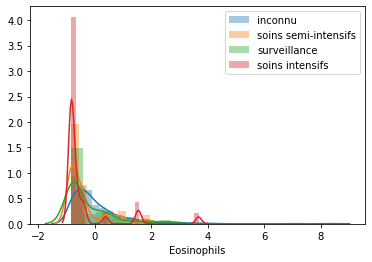

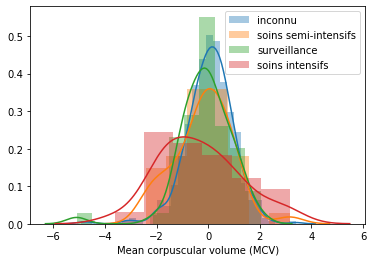

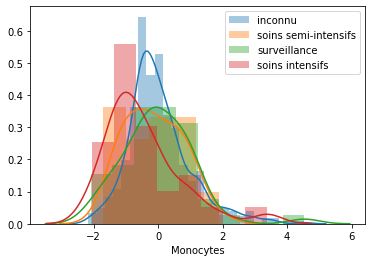

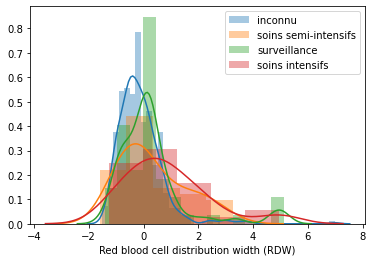

In [38]:
for col in blood_columns:
    plt.figure()
    for cat in df['statut'].unique():
        sns.distplot(df[df['statut']==cat][col], label = cat)
    plt.legend()

# Analyse des NaN

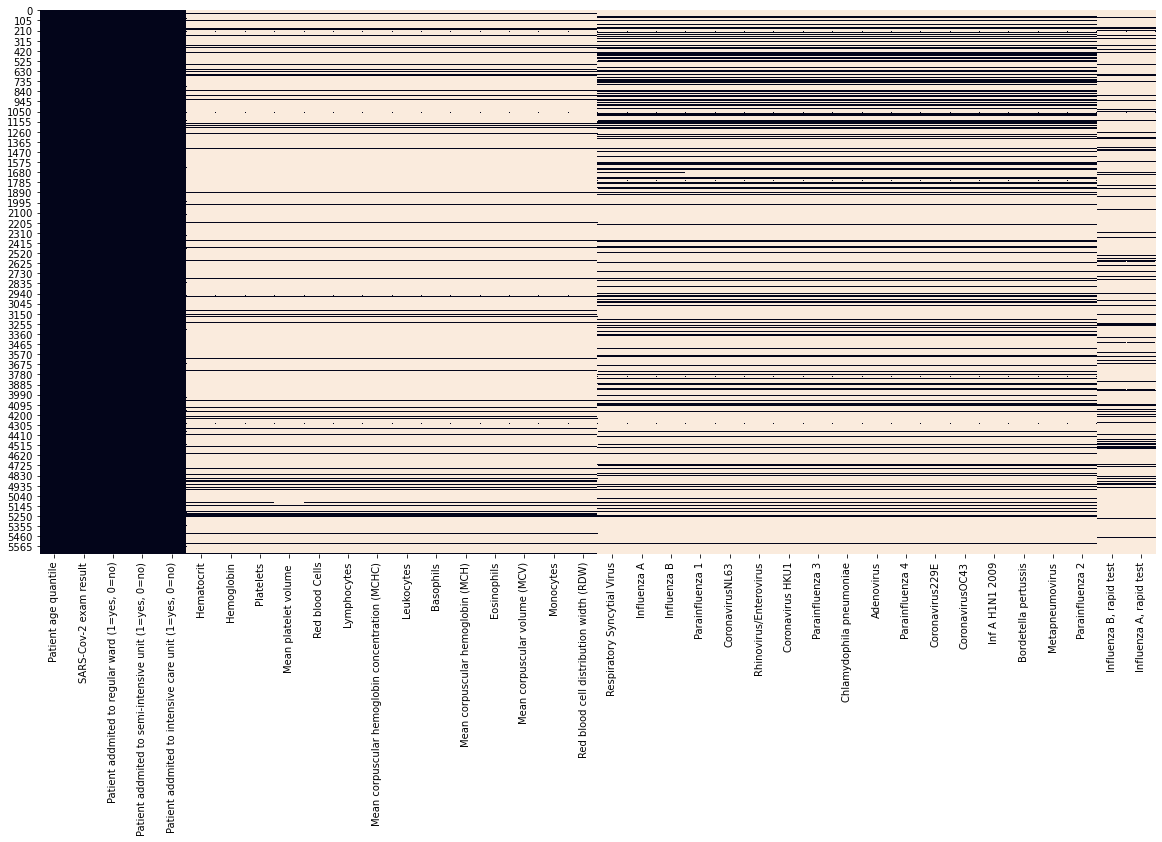

In [39]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.isna().loc[:, df.columns[:-2]], cbar=False)

D'après cette figure, on remarque que les categories blood et les categories viral ne sont pas alignées. Eliminer les colonnes de l'une ou de l'autre risque de perturber l'analyse.

In [40]:
df.dropna().count()

Patient age quantile                                     99
SARS-Cov-2 exam result                                   99
Patient addmited to regular ward (1=yes, 0=no)           99
Patient addmited to semi-intensive unit (1=yes, 0=no)    99
Patient addmited to intensive care unit (1=yes, 0=no)    99
Hematocrit                                               99
Hemoglobin                                               99
Platelets                                                99
Mean platelet volume                                     99
Red blood Cells                                          99
Lymphocytes                                              99
Mean corpuscular hemoglobin concentration (MCHC)         99
Leukocytes                                               99
Basophils                                                99
Mean corpuscular hemoglobin (MCH)                        99
Eosinophils                                              99
Mean corpuscular volume (MCV)           

Si on éliminait toutes les valeurs manquantes il ne nous resterait que 99 valeurs pour chaque colonne. L'idéal serait peut-être de remplir ces données manquantes.

In [41]:
#Nombre de valeurs présentes dans notre dataset si on retire toutes les valeurs 
#manquantes de blood_columns
df[blood_columns].count()

Hematocrit                                          603
Hemoglobin                                          603
Platelets                                           602
Mean platelet volume                                599
Red blood Cells                                     602
Lymphocytes                                         602
Mean corpuscular hemoglobin concentration (MCHC)    602
Leukocytes                                          602
Basophils                                           602
Mean corpuscular hemoglobin (MCH)                   602
Eosinophils                                         602
Mean corpuscular volume (MCV)                       602
Monocytes                                           601
Red blood cell distribution width (RDW)             602
dtype: int64

In [42]:
#Nombre de valeurs présentes dans notre dataset si on retire toutes les valeurs 
#manquantes de viral_columns
df[viral_colums].count()

Respiratory Syncytial Virus    1354
Influenza A                    1354
Influenza B                    1354
Parainfluenza 1                1352
CoronavirusNL63                1352
Rhinovirus/Enterovirus         1352
Coronavirus HKU1               1352
Parainfluenza 3                1352
Chlamydophila pneumoniae       1352
Adenovirus                     1352
Parainfluenza 4                1352
Coronavirus229E                1352
CoronavirusOC43                1352
Inf A H1N1 2009                1352
Bordetella pertussis           1352
Metapneumovirus                1352
Parainfluenza 2                1352
Influenza B, rapid test         820
Influenza A, rapid test         820
dtype: int64

In [43]:
#Essayons de comprendre quel serait l'état de notre target si on éliminait toutes les valeurs manquantes
#--> Pour les valeurs manquantes de viral_columns
df1 = df[viral_colums[:-2]]
df1['covid'] = df['SARS-Cov-2 exam result']
df1.dropna()['covid'].value_counts(normalize=True)

<ipython-input-43-3b9b23c8257c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['covid'] = df['SARS-Cov-2 exam result']


negative    0.91716
positive    0.08284
Name: covid, dtype: float64

On garde presque les mêmes proportions

In [44]:
#--> Pour les valeurs manquantes de blood_columns
df2 = df[blood_columns]
df2['covid'] = df['SARS-Cov-2 exam result']
df2.dropna()['covid'].value_counts(normalize=True)

<ipython-input-44-074a89ca75cf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['covid'] = df['SARS-Cov-2 exam result']


negative    0.864548
positive    0.135452
Name: covid, dtype: float64

On a de meilleures proportions mais très peu de valeurs.

In [45]:
#Essayons de comprendre quel serait l'état de notre target si on éliminait toutes les valeurs manquantes
#--> Pour les valeurs manquantes des deux
df3 = df[list(viral_colums[:-2])+list(blood_columns)]
df3['covid'] = df['SARS-Cov-2 exam result']
df3.dropna()['covid'].value_counts(normalize=True)

<ipython-input-45-815401741d2f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['covid'] = df['SARS-Cov-2 exam result']


negative    0.861878
positive    0.138122
Name: covid, dtype: float64

# Tester les hypothèses

Hypothèses nulles (H0):<br>
<ul>
    <li> Les individus positifs au covid ont un taux de Leukocytes, Platelets et Monocytes significativement différents de ceux qui sont négatifs.<br>
    <ul>
        <li>H0 = Les taux moyens sont égaux chez les individus positifs et négatifs.</li>
    </ul></li>
    <li>Les individus positifs d'une quelconque maladie ont des taux significativement différents.</li>
</ul>

In [46]:
#Testons l'hypothèse H0 avec le test de student
'''Le test de student est un test qui permet de vérifier si la moyenne
entre deux distributions est significativement différente'''

from scipy.stats import ttest_ind

In [47]:
print(positive_df.shape, negative_df.shape)

(558, 38) (5086, 38)


Il y a un gros déséquilibre entre les tests positifs et les tests négatifs.
Le test de student a besoin d'avoir des classes balancées entre nos différents groupes. Le nombre de tests positifs doit être quasiment égal au nombre de tests négatifs.
Ce qu'on va faire c'est de tirer quelques échantillons dans negative_df pour les équilibrer.

In [51]:
balanced_neg = negative_df.sample(positive_df.shape[0]) #558 échantillons tirées au hasard dans notre dataframe

On va les intégrer dans une fonction qui va faire appel à <i>ttest_ind</i> qui va calculer la valeur <b>p</b> entre <i>positif_df</i> et <i>balanced_neg</i> pour chaque colonne de <i>blood_columns</i> et la comparer à un seuil <i>alpha</i>

In [52]:
def t_test(col):
    alpha = 0.02
    stat, p = ttest_ind(balanced_neg[col].dropna(), positive_df[col].dropna()) #On élimine les valeurs manquantes pour avoir un bon test
    if p < alpha:
        return 'H0 rejetée'
    else:
        return 0

In [55]:
for col in blood_columns:
    print(f'{col:-<50}{t_test(col)}')

Hematocrit----------------------------------------0
Hemoglobin----------------------------------------0
Platelets-----------------------------------------H0 rejetée
Mean platelet volume -----------------------------0
Red blood Cells-----------------------------------0
Lymphocytes---------------------------------------0
Mean corpuscular hemoglobin concentration (MCHC)--0
Leukocytes----------------------------------------H0 rejetée
Basophils-----------------------------------------0
Mean corpuscular hemoglobin (MCH)-----------------0
Eosinophils---------------------------------------H0 rejetée
Mean corpuscular volume (MCV)---------------------0
Monocytes-----------------------------------------H0 rejetée
Red blood cell distribution width (RDW)-----------0


Les taux moyens ne sont pas égaux chez les individus positifs ou négatifs. 

# Preprocessing

Après avoir fini l'EDA, on ramène notre dataframe à son état initial pour le preprocessing

In [120]:
df = data.copy()

In [121]:
df.head()

Patient ID  Patient age quantile SARS-Cov-2 exam result  \
0  44477f75e8169d2                    13               negative   
1  126e9dd13932f68                    17               negative   
2  a46b4402a0e5696                     8               negative   
3  f7d619a94f97c45                     5               negative   
4  d9e41465789c2b5                    15               negative   

   Patient addmited to regular ward (1=yes, 0=no)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Patient addmited to semi-intensive unit (1=yes, 0=no)  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   Patient addmited to intensive care unit (1=yes, 0=no)  Hematocrit  \
0                                                  0             NaN   
1                                                  0        0.236515   
2                                                  0             NaN   
3                                                  0             NaN   
4                                                  0             NaN   

   Hemoglobin  Platelets  Mean platelet volume   Red blood Cells  Lymphocytes  \
0         NaN        NaN                    NaN              NaN          NaN   
1    -0.02234  -0.517413               0.010677         0.102004     0.318366   
2         NaN        NaN                    NaN              NaN          NaN   
3         NaN        NaN                    NaN              NaN          NaN   
4         NaN        NaN                    NaN              NaN          NaN   

   Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  Basophils  \
0                                               NaN         NaN        NaN   
1                                          -0.95079    -0.09461  -0.223767   
2                                               NaN         NaN        NaN   
3                                               NaN         NaN        NaN   
4                                               NaN         NaN        NaN   

   Mean corpuscular hemoglobin (MCH)  Eosinophils  \
0                                NaN          NaN   
1                          -0.292269     1.482158   
2                                NaN          NaN   
3                                NaN          NaN   
4                                NaN          NaN   

   Mean corpuscular volume (MCV)  Monocytes  \
0                            NaN        NaN   
1                       0.166192   0.357547   
2                            NaN        NaN   
3                            NaN        NaN   
4                            NaN        NaN   

   Red blood cell distribution width (RDW)  Serum Glucose  \
0                                      NaN            NaN   
1                                -0.625073      -0.140648   
2                                      NaN            NaN   
3                                      NaN            NaN   
4                                      NaN            NaN   

  Respiratory Syncytial Virus   Influenza A   Influenza B Parainfluenza 1  \
0                         NaN           NaN           NaN             NaN   
1                not_detected  not_detected  not_detected    not_detected   
2                         NaN           NaN           NaN             NaN   
3                         NaN           NaN           NaN             NaN   
4                not_detected  not_detected  not_detected    not_detected   

  CoronavirusNL63 Rhinovirus/Enterovirus  Mycoplasma pneumoniae  \
0             NaN                    

In [122]:
missing_rate = df.isna().sum()/df.shape[0]

In [123]:
#Les colonnes à garder : Les colonnes de blood, de viral, l'âge et bien-sûr notre target

blood_columns = list(df.columns[(missing_rate < 0.90) & (missing_rate > 0.88)])
viral_columns = list(df.columns[(missing_rate < 0.80) & (missing_rate > 0.75)])
key_columns = ['Patient age quantile', 'SARS-Cov-2 exam result']

In [124]:
#On ne va garder que les 33 colonnes importantes
df = df[key_columns + blood_columns + viral_columns]
print(df.shape)

df.head()

(5644, 33)


Patient age quantile SARS-Cov-2 exam result  Hematocrit  Hemoglobin  \
0                    13               negative         NaN         NaN   
1                    17               negative    0.236515    -0.02234   
2                     8               negative         NaN         NaN   
3                     5               negative         NaN         NaN   
4                    15               negative         NaN         NaN   

   Platelets  Mean platelet volume   Red blood Cells  Lymphocytes  \
0        NaN                    NaN              NaN          NaN   
1  -0.517413               0.010677         0.102004     0.318366   
2        NaN                    NaN              NaN          NaN   
3        NaN                    NaN              NaN          NaN   
4        NaN                    NaN              NaN          NaN   

   Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  Basophils  \
0                                               NaN         NaN        NaN   
1                                          -0.95079    -0.09461  -0.223767   
2                                               NaN         NaN        NaN   
3                                               NaN         NaN        NaN   
4                                               NaN         NaN        NaN   

   Mean corpuscular hemoglobin (MCH)  Eosinophils  \
0                                NaN          NaN   
1                          -0.292269     1.482158   
2                                NaN          NaN   
3                                NaN          NaN   
4                                NaN          NaN   

   Mean corpuscular volume (MCV)  Monocytes  \
0                            NaN        NaN   
1                       0.166192   0.357547   
2                            NaN        NaN   
3                            NaN        NaN   
4                            NaN        NaN   

   Red blood cell distribution width (RDW) Respiratory Syncytial Virus  \
0                                      NaN                         NaN   
1                                -0.625073                not_detected   
2                                      NaN                         NaN   
3                                      NaN                         NaN   
4                                      NaN                not_detected   

    Influenza A   Influenza B Parainfluenza 1 CoronavirusNL63  \
0           NaN           NaN             NaN             NaN   
1  not_detected  not_detected    not_detected    not_detected   
2           NaN           NaN             NaN             NaN   
3           NaN           NaN             NaN             NaN   
4  not_detected  not_detected    not_detected    not_detected   

  Rhinovirus/Enterovirus Coronavirus HKU1 Parainfluenza 3  \
0                    NaN              NaN             NaN   
1               detected     not_detected    not_detected   
2                    NaN              NaN             NaN   
3                    NaN              NaN             NaN   
4               detected     not_detected    not_detected   

  Chlamydophila pneumoniae    Adenovirus Parainfluenza 4 Coronavirus229E  \
0                      NaN           NaN             NaN             NaN   
1             not_detected  not_detected    not_detected    not_detected   
2                      NaN           NaN             NaN             NaN   
3                      NaN           NaN             NaN             NaN   
4             not_detected  not_detected    not_detected    not_detected   

  CoronavirusOC43 Inf A H1N1 2009 Bordetella pertussis Metapneumovirus  \
0             NaN             NaN                  NaN             NaN   
1    not_detected    not_detected         not_detected    not_detected   
2             NaN             NaN                  NaN             NaN   
3             NaN             NaN                  NaN             NaN   
4    not_detected    not_detected         

# TrainTest - Nettoyage - Encodage

In [125]:
from sklearn.model_selection import train_test_split

In [126]:
trainset, testset = train_test_split(df, test_size = 0.2, random_state = 0)

print(trainset.shape, testset.shape)

(4515, 33) (1129, 33)


In [127]:
trainset['SARS-Cov-2 exam result'].value_counts()

negative    4068
positive     447
Name: SARS-Cov-2 exam result, dtype: int64

In [128]:
testset['SARS-Cov-2 exam result'].value_counts()

negative    1018
positive     111
Name: SARS-Cov-2 exam result, dtype: int64

<h5>Encodage

In [129]:
def encodage(df):    
    code = {
        'positive':1,
        'negative':0,
        'detected':1,
        'not_detected':0
    }
    for col in df.select_dtypes('object').columns:
        df.loc[:, col] = df[col].map(code)

    return df

In [130]:
encodage(df)
df.head()

Patient age quantile  SARS-Cov-2 exam result  Hematocrit  Hemoglobin  \
0                    13                       0         NaN         NaN   
1                    17                       0    0.236515    -0.02234   
2                     8                       0         NaN         NaN   
3                     5                       0         NaN         NaN   
4                    15                       0         NaN         NaN   

   Platelets  Mean platelet volume   Red blood Cells  Lymphocytes  \
0        NaN                    NaN              NaN          NaN   
1  -0.517413               0.010677         0.102004     0.318366   
2        NaN                    NaN              NaN          NaN   
3        NaN                    NaN              NaN          NaN   
4        NaN                    NaN              NaN          NaN   

   Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  Basophils  \
0                                               NaN         NaN        NaN   
1                                          -0.95079    -0.09461  -0.223767   
2                                               NaN         NaN        NaN   
3                                               NaN         NaN        NaN   
4                                               NaN         NaN        NaN   

   Mean corpuscular hemoglobin (MCH)  Eosinophils  \
0                                NaN          NaN   
1                          -0.292269     1.482158   
2                                NaN          NaN   
3                                NaN          NaN   
4                                NaN          NaN   

   Mean corpuscular volume (MCV)  Monocytes  \
0                            NaN        NaN   
1                       0.166192   0.357547   
2                            NaN        NaN   
3                            NaN        NaN   
4                            NaN        NaN   

   Red blood cell distribution width (RDW)  Respiratory Syncytial Virus  \
0                                      NaN                          NaN   
1                                -0.625073                          0.0   
2                                      NaN                          NaN   
3                                      NaN                          NaN   
4                                      NaN                          0.0   

   Influenza A  Influenza B  Parainfluenza 1  CoronavirusNL63  \
0          NaN          NaN              NaN              NaN   
1          0.0          0.0              0.0              0.0   
2          NaN          NaN              NaN              NaN   
3          NaN          NaN              NaN              NaN   
4          0.0          0.0              0.0              0.0   

   Rhinovirus/Enterovirus  Coronavirus HKU1  Parainfluenza 3  \
0                     NaN               NaN              NaN   
1                     1.0               0.0              0.0   
2                     NaN               NaN              NaN   
3                     NaN               NaN              NaN   
4                     1.0               0.0              0.0   

   Chlamydophila pneumoniae  Adenovirus  Parainfluenza 4  Coronavirus229E  \
0                       NaN         NaN              NaN              NaN   
1                       0.0         0.0              0.0              0.0   
2                       NaN         NaN              NaN              NaN   
3                       NaN         NaN              NaN              NaN   
4                       0.0         0.0              0.0              0.0   

   CoronavirusOC43  Inf A H1N1 2009  Bordetella pertussis  Metapneumovirus  \
0              NaN              NaN                   NaN              NaN   
1              0.0              0.0                   0.0              0.0   
2              NaN              NaN                   NaN              NaN   
3              NaN              NaN                   NaN       

In [131]:
df.dtypes.value_counts()

float64    31
int64       2
dtype: int64

In [132]:
def imputation(df): #Version 1
    return df.dropna(axis=0)

In [133]:
def preprocessing(df):
    df = encodage(df)
    df = imputation(df)
    X = df.drop('SARS-Cov-2 exam result', axis = 1)
    y = df['SARS-Cov-2 exam result']

    print(y.value_counts())

    return X, y

In [134]:
X_train, y_train = preprocessing(trainset)

0    258
1     38
Name: SARS-Cov-2 exam result, dtype: int64


/home/emman/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [135]:
X_test, y_test = preprocessing(testset)

0    54
1    12
Name: SARS-Cov-2 exam result, dtype: int64


<h5>Modellisation</h5>

In [136]:
from sklearn.tree import DecisionTreeClassifier

In [137]:
model = DecisionTreeClassifier(random_state=0)

Procedure d'évaluation

In [138]:
from sklearn.metrics import f1_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [139]:
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv= 4, train_sizes = np.linspace(0.1, 1, 10), scoring = 'f1')
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label = 'train score')
    plt.plot(N, val_score.mean(axis=1), label = 'validation score')
    plt.legend()

[[52  2]
 [10  2]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        54
           1       0.50      0.17      0.25        12

    accuracy                           0.82        66
   macro avg       0.67      0.56      0.57        66
weighted avg       0.78      0.82      0.78        66



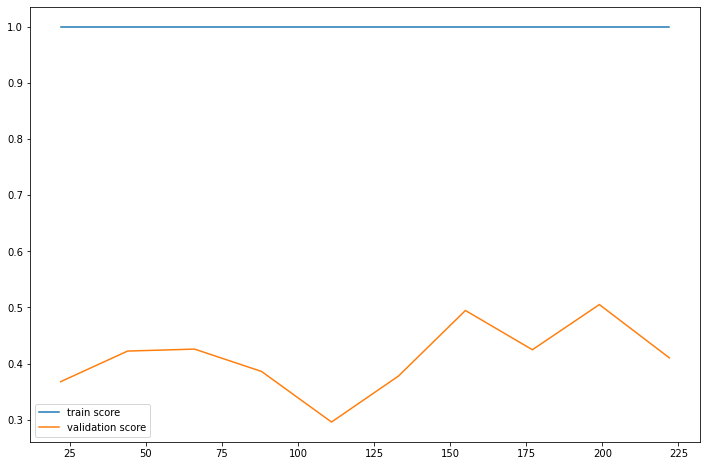

In [140]:
evaluation(model)

Le modèle est en overfitting. Il apprend parfaitement sur les données du train set mais lorsqu'il s'agit de les tester sur le validation set il est incapable de faire de bonnes prédictions. Au mieux il fait environ 50% de score f1 (ce qui est déjà un bon début)<br>
On doit lutter contre cet overfitting en essayant de modifier les étapes du preprocessing. Essayons par exemple de lui donner plus de données.

In [105]:
# Essayons de modifier la fonction imputation.
# Au lieu de retirer toutes le valeurs manquantes essayons de leur donner une nouvelle valeur
def imputation(df): #Version 2
    return df.fillna(-999)

In [106]:
X_train, y_train = preprocessing(trainset)

0    4068
1     447
Name: SARS-Cov-2 exam result, dtype: int64


In [107]:
X_test, y_test = preprocessing(testset)

0    1018
1     111
Name: SARS-Cov-2 exam result, dtype: int64


On a déjà beaucoup plus de valeurs. C'est peut-être mieux.

[[1011    7]
 [ 105    6]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1018
           1       0.46      0.05      0.10       111

    accuracy                           0.90      1129
   macro avg       0.68      0.52      0.52      1129
weighted avg       0.86      0.90      0.86      1129



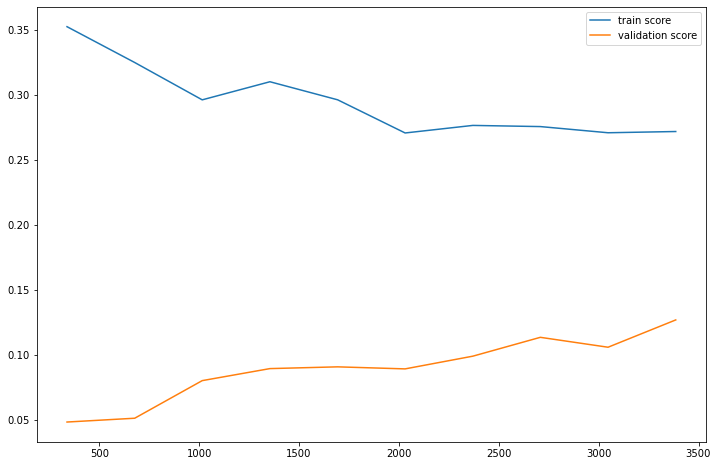

In [108]:
evaluation(model)

Oups ! C'est pire ! Le train score est en dessous de 50%, le score de validation c'est encore pire.

Ajouter des données ça peut nous aider mais nous ne devrions pas nous contenter d'ajouter -999. Essayons une autre méthode.

In [109]:
def imputation(df): #Version 3
    df['is na'] = (df['Parainfluenza 2'].isna()) | (df['Leukocytes'].isna())
    return df.dropna()

In [110]:
X_train, y_train = preprocessing(trainset)

0    4068
1     447
Name: SARS-Cov-2 exam result, dtype: int64


<ipython-input-109-c07bf840b804>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is na'] = (df['Parainfluenza 2'].isna()) | (df['Leukocytes'].isna())


In [111]:
X_test, y_test = preprocessing(testset)

0    1018
1     111
Name: SARS-Cov-2 exam result, dtype: int64


<ipython-input-109-c07bf840b804>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is na'] = (df['Parainfluenza 2'].isna()) | (df['Leukocytes'].isna())


[[1009    9]
 [ 105    6]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1018
           1       0.40      0.05      0.10       111

    accuracy                           0.90      1129
   macro avg       0.65      0.52      0.52      1129
weighted avg       0.86      0.90      0.86      1129



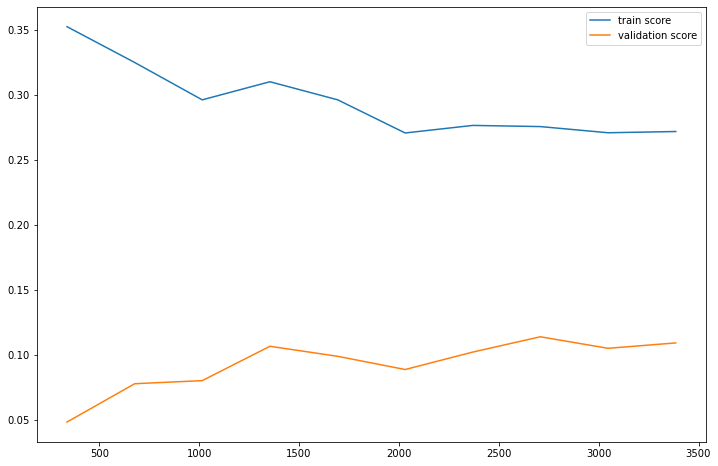

In [112]:
evaluation(model)

Le fillna n'est pas une bonne idée. Changeons d'idées

In [114]:
def imputation(df): #Version 1
    return df.dropna(axis=0)

0    258
1     38
Name: SARS-Cov-2 exam result, dtype: int64
0    54
1    12
Name: SARS-Cov-2 exam result, dtype: int64
[[52  2]
 [10  2]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        54
           1       0.50      0.17      0.25        12

    accuracy                           0.82        66
   macro avg       0.67      0.56      0.57        66
weighted avg       0.78      0.82      0.78        66



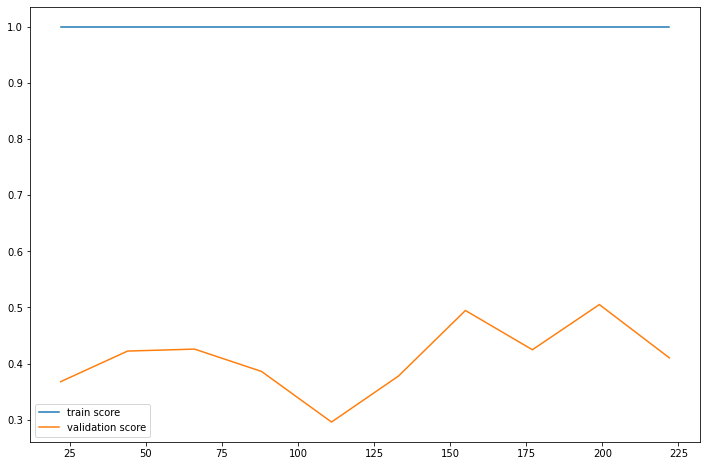

In [141]:
X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)
evaluation(model)

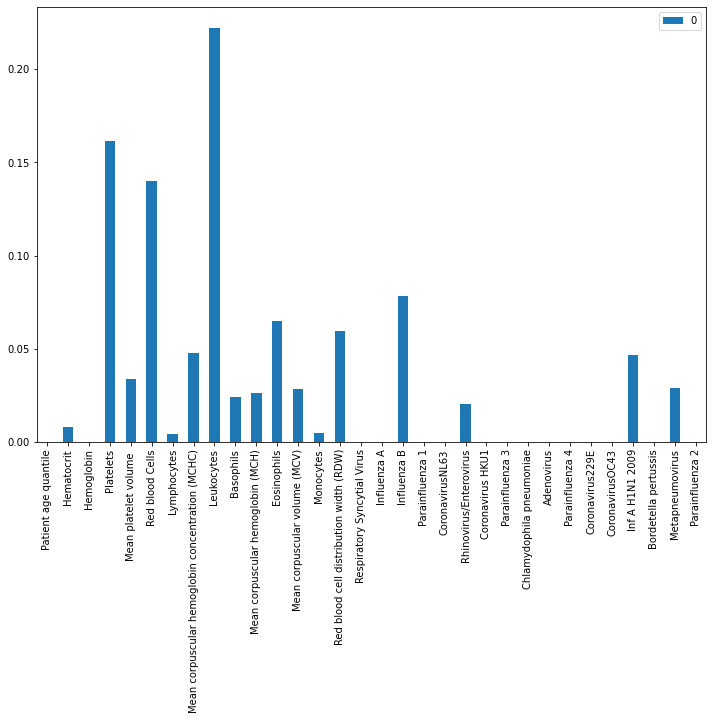

In [142]:
pd.DataFrame(model.feature_importances_, index=X_train.columns).plot.bar(figsize=(12,8))

On remarque que la majorité des features les moins importantes sont de type viral.

In [154]:
df = data.copy()
df = encodage(df)

#Essayons de ne garder que les autres colonnes
df = df[key_columns + blood_columns]# + viral_columns]
print(df.shape)
df.head()
trainset, testset = train_test_split(df, test_size = 0.2, random_state = 0)

print(trainset.shape, testset.shape)

In [158]:
X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)
evaluation(model)

0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64


On ne voit pas une grande amélioration. Essayons un autre modèle, un modèle qui lutte contre l'overfitting.

In [160]:
from sklearn.ensemble import RandomForestClassifier

In [161]:
model = RandomForestClassifier(random_state=0)

In [162]:
df = data.copy()
df = encodage(df)

#Essayons de remettre les colonnes virales
df = df[key_columns + blood_columns + viral_columns]
print(df.shape)
df.head()
trainset, testset = train_test_split(df, test_size = 0.2, random_state = 0)

print(trainset.shape, testset.shape)

(5644, 33)
(4515, 33) (1129, 33)


0    258
1     38
Name: SARS-Cov-2 exam result, dtype: int64
0    54
1    12
Name: SARS-Cov-2 exam result, dtype: int64
[[54  0]
 [11  1]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        54
           1       1.00      0.08      0.15        12

    accuracy                           0.83        66
   macro avg       0.92      0.54      0.53        66
weighted avg       0.86      0.83      0.77        66



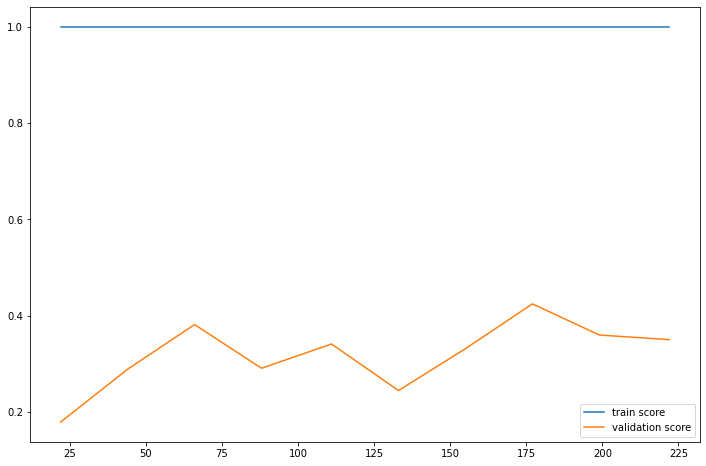

In [163]:
X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)
evaluation(model)

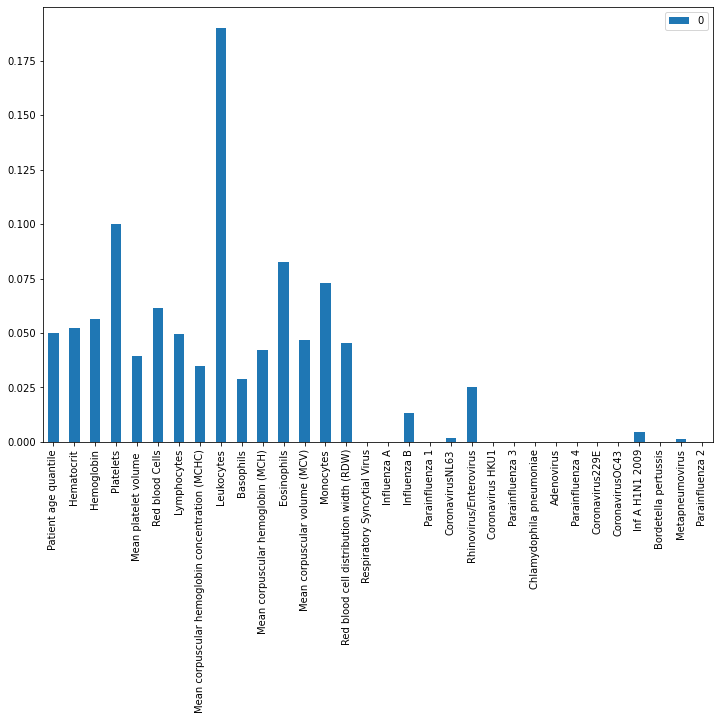

In [164]:
pd.DataFrame(model.feature_importances_, index=X_train.columns).plot.bar(figsize=(12, 8))